C:\Users\ayhan\AppData\Local\Temp\ipykernel_21356\1731843348.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10')


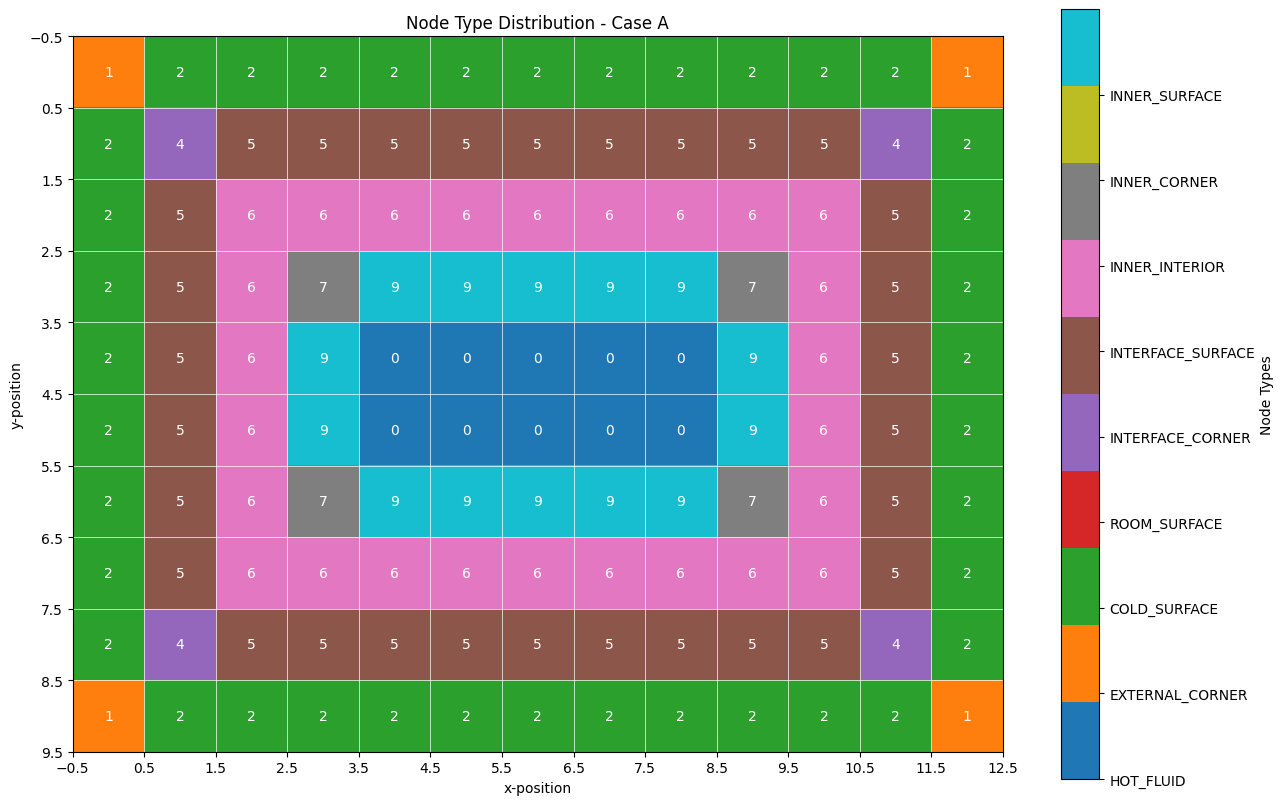

C:\Users\ayhan\AppData\Local\Temp\ipykernel_21356\1731843348.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10')


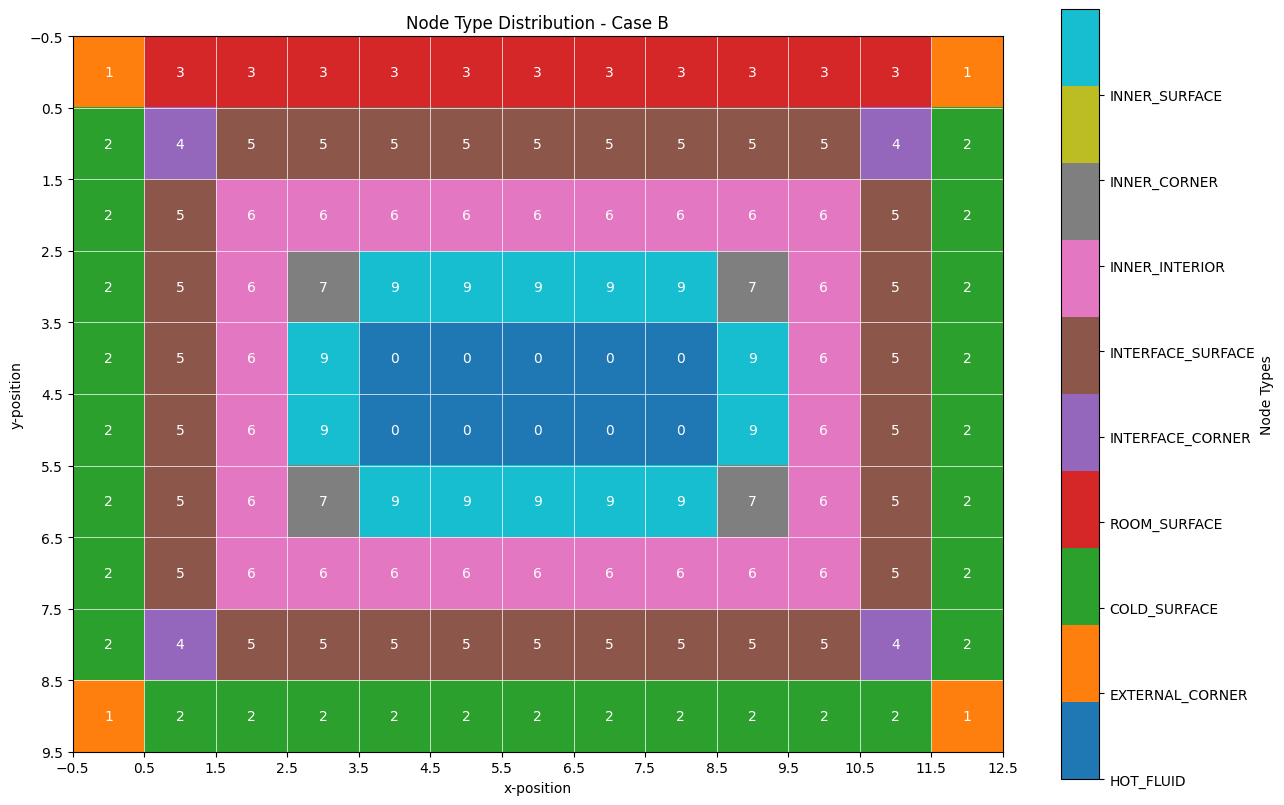

In [2]:
import numpy as np
from enum import Enum
import numpy as np
from scipy.sparse import lil_matrix, csc_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt


class NodeType(Enum):
    HOT_FLUID = 0          # Hot fluid region
    EXTERNAL_CORNER = 1    # External corners of the structure
    COLD_SURFACE = 2       # Cold surface boundaries
    ROOM_SURFACE = 3       # Room temperature surface (case b only)
    INTERFACE_CORNER = 4   # Corners at material interfaces
    INTERFACE_SURFACE = 5  # Surface between materials
    INNER_INTERIOR = 6     # Interior nodes of inner material
    INNER_CORNER = 7       # Inner corners adjacent to hot fluid
    INNER_SURFACE = 9      # Inner surface adjacent to hot fluid

class ChimneyAnalysis:
    def __init__(self, nx=13, ny=10, case='a'):
        # Thermal properties
        self.T_cold = 4.0
        self.T_room = 24.0
        self.T_hot = 300.0
        self.h_cold = 25.0
        self.h_room = 4.0
        self.h_hot = 90.0
        self.k_inner = 45.0
        self.k_outer = 15.0
        
        # Grid properties
        self.nx = nx
        self.ny = ny
        self.dx = 0.20  # 20 cm in meters
        self.case = case
        
        # Initialize grid
        self.node_types = self.setup_node_types()
    
    def setup_node_types(self):
        """Setup the node types based on the given pattern"""
        if self.case == 'a':
            return np.array([
                [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1],
                [2, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 2],
                [2, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 2],
                [2, 5, 6, 7, 9, 9, 9, 9, 9, 7, 6, 5, 2],
                [2, 5, 6, 9, 0, 0, 0, 0, 0, 9, 6, 5, 2],
                [2, 5, 6, 9, 0, 0, 0, 0, 0, 9, 6, 5, 2],
                [2, 5, 6, 7, 9, 9, 9, 9, 9, 7, 6, 5, 2],
                [2, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 2],
                [2, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 2],
                [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1]
            ])
        else:  # case 'b'
            return np.array([
                [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1],
                [2, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 2],
                [2, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 2],
                [2, 5, 6, 7, 9, 9, 9, 9, 9, 7, 6, 5, 2],
                [2, 5, 6, 9, 0, 0, 0, 0, 0, 9, 6, 5, 2],
                [2, 5, 6, 9, 0, 0, 0, 0, 0, 9, 6, 5, 2],
                [2, 5, 6, 7, 9, 9, 9, 9, 9, 7, 6, 5, 2],
                [2, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 2],
                [2, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 2],
                [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1]
            ])

    def get_node_number(self, i, j):
        """Convert 2D indices to node number."""
        return i * self.nx + j
    
    def get_neighbor_nodes(self, i, j):
        """Get valid neighbor node numbers."""
        neighbors = []
        for ni, nj in [(i-1,j), (i+1,j), (i,j-1), (i,j+1)]:
            if 0 <= ni < self.ny and 0 <= nj < self.nx:
                neighbors.append(self.get_node_number(ni, nj))
        return neighbors

def plot_node_types(solver):
    """Visualize node type distribution with proper coloring"""
    plt.figure(figsize=(15, 10))
    
    # Create a custom colormap for the different node types
    cmap = plt.cm.get_cmap('tab10')
    plt.imshow(solver.node_types, cmap=cmap)
    
    # Add colorbar with node type names
    cbar = plt.colorbar(label='Node Types')
    cbar.set_ticks(range(9))
    cbar.set_ticklabels([type.name for type in NodeType])
    
    plt.title(f'Node Type Distribution - Case {solver.case.upper()}')
    plt.xlabel('x-position')
    plt.ylabel('y-position')
    
    # Add grid lines
    plt.grid(True, which='major', color='white', linewidth=0.5)
    plt.xticks(np.arange(-0.5, solver.nx, 1))
    plt.yticks(np.arange(-0.5, solver.ny, 1))
    
    # Add node type numbers
    for i in range(solver.ny):
        for j in range(solver.nx):
            plt.text(j, i, str(solver.node_types[i,j]), 
                    ha='center', va='center', color='white')
    
    plt.show()

# Test Case A
solver_a = ChimneyAnalysis(case='a')
plot_node_types(solver_a)

# Test Case B
solver_b = ChimneyAnalysis(case='b')
plot_node_types(solver_b)

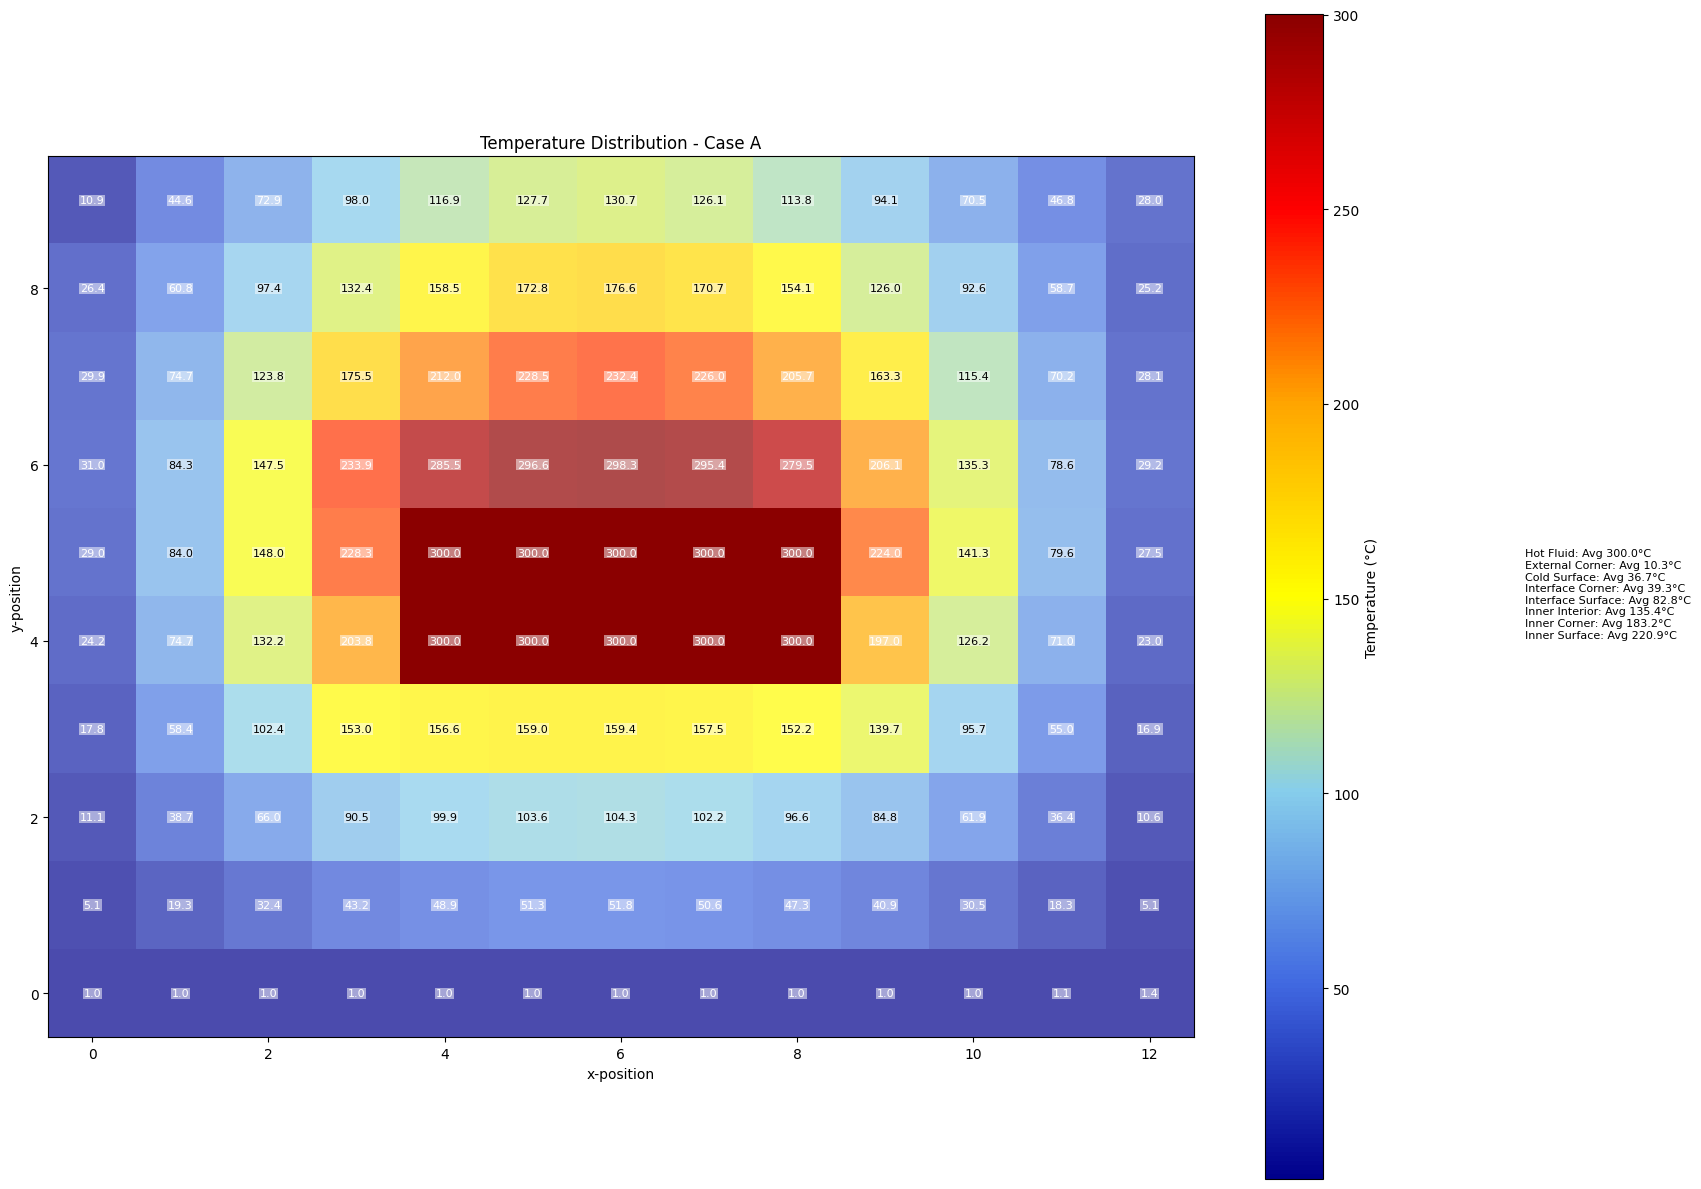

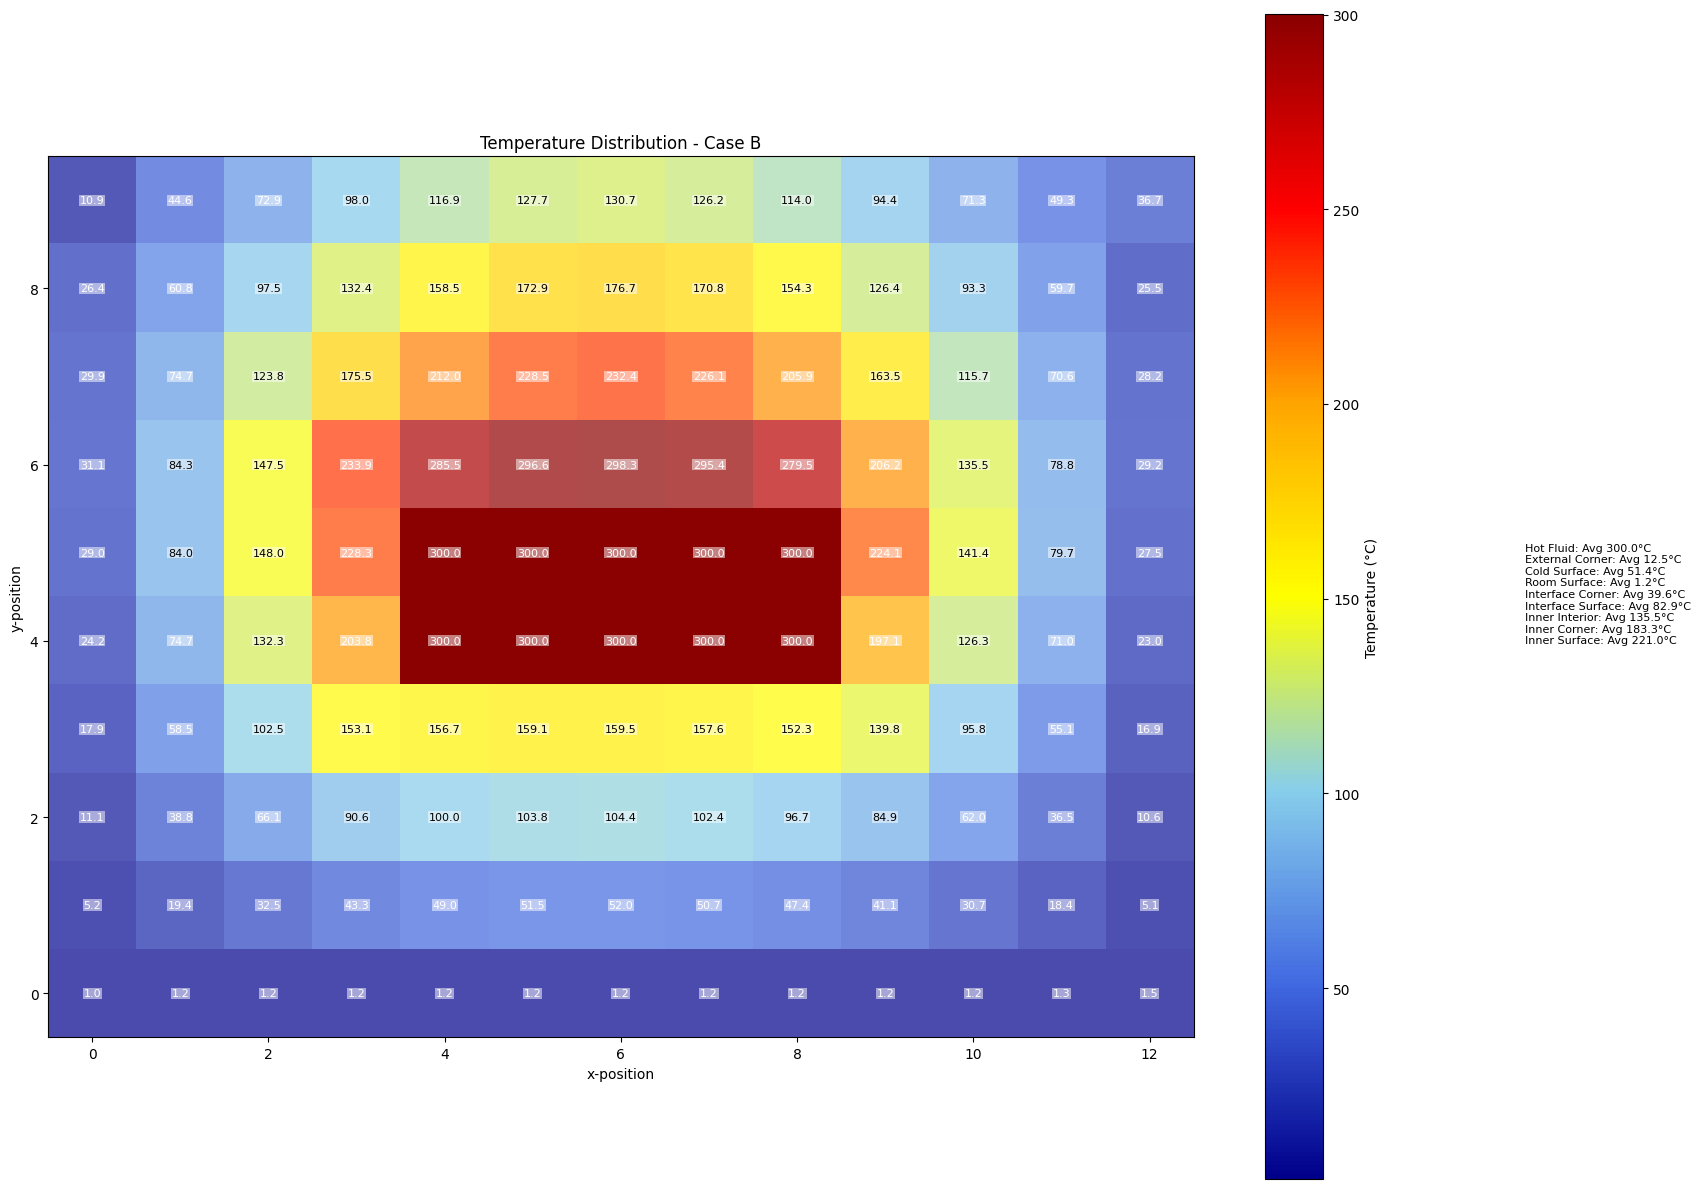

In [4]:
import numpy as np
from scipy.sparse import lil_matrix, csc_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
from enum import Enum
from typing import List, Tuple, Set

class NodeType(Enum):
    HOT_FLUID = 0          # Hot fluid region
    EXTERNAL_CORNER = 1    # External corners
    COLD_SURFACE = 2       # Cold surface boundaries
    ROOM_SURFACE = 3       # Room temperature surface
    INTERFACE_CORNER = 4   # Corners at interfaces
    INTERFACE_SURFACE = 5  # Surface between materials
    INNER_INTERIOR = 6     # Interior nodes of inner material
    INNER_CORNER = 7       # Inner corners near hot fluid
    INNER_SURFACE = 9      # Inner surface near hot fluid

class ChimneyAnalysis:
    def __init__(self, nx=13, ny=10, case='a'):
        # Thermal properties
        self.T_cold = 4.0
        self.T_room = 24.0
        self.T_hot = 300.0
        self.h_cold = 25.0
        self.h_room = 4.0
        self.h_hot = 90.0
        self.k_inner = 45.0
        self.k_outer = 15.0
        
        # Grid properties
        self.nx = nx
        self.ny = ny
        self.dx = 0.20  # 20 cm in meters
        self.case = case
        
        # Initialize grids and maps
        self.node_types = self.setup_node_types()
        self.material_grid = self.setup_material_grid()
        self.neighbor_materials = self.setup_neighbor_materials()

    def setup_node_types(self):
        """Setup the node types based on the given pattern"""
        if self.case == 'a':
            return np.array([
                [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1],
                [2, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 2],
                [2, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 2],
                [2, 5, 6, 7, 9, 9, 9, 9, 9, 7, 6, 5, 2],
                [2, 5, 6, 9, 0, 0, 0, 0, 0, 9, 6, 5, 2],
                [2, 5, 6, 9, 0, 0, 0, 0, 0, 9, 6, 5, 2],
                [2, 5, 6, 7, 9, 9, 9, 9, 9, 7, 6, 5, 2],
                [2, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 2],
                [2, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 2],
                [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1]
            ])
        else:  # case 'b'
            return np.array([
                [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1],
                [2, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 2],
                [2, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 2],
                [2, 5, 6, 7, 9, 9, 9, 9, 9, 7, 6, 5, 2],
                [2, 5, 6, 9, 0, 0, 0, 0, 0, 9, 6, 5, 2],
                [2, 5, 6, 9, 0, 0, 0, 0, 0, 9, 6, 5, 2],
                [2, 5, 6, 7, 9, 9, 9, 9, 9, 7, 6, 5, 2],
                [2, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 2],
                [2, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 2],
                [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1]
            ])

    def setup_material_grid(self):
        """Setup material grid with correct material assignments
        
        Material grid represents actual materials:
        - True for both k_inner and k_outer regions (both are solid materials)
        - False only for HOT_FLUID region (not a material)
        """
        material_grid = np.ones((self.ny, self.nx), dtype=bool)  # Initialize all as True
        
        # Set only HOT_FLUID regions to False
        material_grid[self.node_types == NodeType.HOT_FLUID.value] = False
        
        return material_grid

    def setup_neighbor_materials(self):
        """Create a mapping of node positions to their neighbor material types"""
        neighbor_materials = {}
        
        for i in range(self.ny):
            for j in range(self.nx):
                node_type = self.node_types[i,j]
                node_pos = (i, j)
                
                # Get material types of neighboring nodes
                neighbors = self.get_neighbor_materials(i, j)
                neighbor_materials[node_pos] = neighbors
                
        return neighbor_materials

    def get_neighbor_materials(self, i: int, j: int) -> Set[Tuple[int, int, bool]]:
        """Get material types of neighboring nodes"""
        neighbors = set()
        
        for ni, nj in [(i-1,j), (i+1,j), (i,j-1), (i,j+1)]:
            if 0 <= ni < self.ny and 0 <= nj < self.nx:
                # Store neighbor position and its material type
                is_inner = self.material_grid[ni,nj]
                neighbors.add((ni, nj, is_inner))
                
        return neighbors

    def get_conductivity(self, i: int, j: int, ni: int, nj: int) -> float:
        """Get effective thermal conductivity between two nodes"""
        node_type = self.node_types[i,j]
        neighbor_type = self.node_types[ni,nj]
        
        # Handle non-material (hot fluid) nodes
        if not self.material_grid[i,j] or not self.material_grid[ni,nj]:
            return 0.0  # No conduction through fluid
            
        # For inner material nodes
        if node_type in [NodeType.INNER_INTERIOR.value, 
                        NodeType.INNER_CORNER.value,
                        NodeType.INNER_SURFACE.value]:
            return self.k_inner
            
        # For outer material nodes
        if node_type in [NodeType.EXTERNAL_CORNER.value,
                        NodeType.COLD_SURFACE.value,
                        NodeType.ROOM_SURFACE.value]:
            return self.k_outer
            
        # For interface nodes, use harmonic mean
        if node_type in [NodeType.INTERFACE_CORNER.value, 
                        NodeType.INTERFACE_SURFACE.value]:
            return 2 * self.k_inner * self.k_outer / (self.k_inner + self.k_outer)

    def get_node_number(self, i: int, j: int) -> int:
        """Convert 2D indices to node number."""
        return i * self.nx + j
    
    def get_neighbor_nodes(self, i: int, j: int) -> List[int]:
        """Get valid neighbor node numbers."""
        neighbors = []
        for ni, nj in [(i-1,j), (i+1,j), (i,j-1), (i,j+1)]:
            if 0 <= ni < self.ny and 0 <= nj < self.nx:
                neighbors.append(self.get_node_number(ni, nj))
        return neighbors

    def set_node_equations(self, A, b, i, j):
        """Set equations for node based on its type using exact finite difference equations"""
        node_type = self.node_types[i,j]
        node = self.get_node_number(i, j)
        dx = self.dx
        
        # Hot fluid nodes
        if node_type == NodeType.HOT_FLUID.value:
            A[node, node] = 1
            b[node] = self.T_hot
            return
        
        # Get all possible neighbor positions
        neighbors = {
            'n': (i-1, j),   # north
            's': (i+1, j),   # south
            'e': (i, j+1),   # east
            'w': (i, j-1)    # west
        }
        
        # Filter valid neighbors
        valid_neighbors = {
            dir: pos for dir, pos in neighbors.items() 
            if 0 <= pos[0] < self.ny and 0 <= pos[1] < self.nx
        }
        
        if node_type == NodeType.INNER_CORNER.value:
            # Equation 4.41: Node at an internal corner with convection
            k = self.k_inner
            h = self.h_hot
            
            # 2(T_{m-1,n} + T_{m,n+1}) + (T_{m+1,n} + T_{m,n-1})
            for dir, (ni, nj) in valid_neighbors.items():
                if dir in ['n', 'e']:  # north and east neighbors get coefficient of 2
                    A[node, self.get_node_number(ni, nj)] = 2
                else:  # south and west neighbors get coefficient of 1
                    A[node, self.get_node_number(ni, nj)] = 1
                    
            # + 2(h∆x/k)T_∞ - 2(3 + h∆x/k)T_{m,n} = 0
            A[node, node] = -2 * (3 + h * dx / k)
            b[node] = -2 * h * dx * self.T_hot / k
            
        elif node_type == NodeType.INNER_SURFACE.value:
            # Equation 4.42: Node at a plane surface with convection (inner)
            k = self.k_inner
            h = self.h_hot
            
            # (2T_{m-1,n} + T_{m,n+1} + T_{m,n-1})
            for dir, (ni, nj) in valid_neighbors.items():
                if dir == 'n':  # north neighbor gets coefficient of 2
                    A[node, self.get_node_number(ni, nj)] = 2
                elif dir in ['e', 'w']:  # east and west neighbors get coefficient of 1
                    A[node, self.get_node_number(ni, nj)] = 1
                    
            # + 2(h∆x/k)T_∞ - 2(h∆x/k + 2)T_{m,n} = 0
            A[node, node] = -2 * (h * dx / k + 2)
            b[node] = -2 * h * dx * self.T_hot / k
            
        elif node_type in [NodeType.COLD_SURFACE.value, NodeType.ROOM_SURFACE.value]:
            # Equation 4.42: Node at a plane surface with convection (outer)
            k = self.k_outer
            h = self.h_cold if node_type == NodeType.COLD_SURFACE.value else self.h_room
            T_inf = self.T_cold if node_type == NodeType.COLD_SURFACE.value else self.T_room
            
            # (2T_{m-1,n} + T_{m,n+1} + T_{m,n-1})
            for dir, (ni, nj) in valid_neighbors.items():
                if dir == 'n':  # north neighbor gets coefficient of 2
                    A[node, self.get_node_number(ni, nj)] = 2
                elif dir in ['e', 'w']:  # east and west neighbors get coefficient of 1
                    A[node, self.get_node_number(ni, nj)] = 1
                    
            # + 2(h∆x/k)T_∞ - 2(h∆x/k + 2)T_{m,n} = 0
            A[node, node] = -2 * (h * dx / k + 2)
            b[node] = -2 * h * dx * T_inf / k
            
        elif node_type == NodeType.EXTERNAL_CORNER.value:
            # Equation 4.43: Node at an external corner with convection
            k = self.k_outer
            h = self.h_cold
            T_inf = self.T_cold
            
            if self.case == 'b' and j == self.nx-1 and i >= self.ny//2:
                h = self.h_room
                T_inf = self.T_room
                
            # (T_{m,n-1} + T_{m-1,n})
            for dir, (ni, nj) in valid_neighbors.items():
                if dir in ['n', 'w']:  # north and west neighbors
                    A[node, self.get_node_number(ni, nj)] = 1
                    
            # + 2(h∆x/k)T_∞ - 2(h∆x/k + 1)T_{m,n} = 0
            A[node, node] = -2 * (h * dx / k + 1)
            b[node] = -2 * h * dx * T_inf / k
            
        elif node_type == NodeType.INNER_INTERIOR.value:
            # Standard 5-point stencil for interior nodes
            k = self.k_inner
            A[node, node] = -4 * k / (dx * dx)
            for _, (ni, nj) in valid_neighbors.items():
                A[node, self.get_node_number(ni, nj)] = k / (dx * dx)
                
        elif node_type in [NodeType.INTERFACE_CORNER.value, NodeType.INTERFACE_SURFACE.value]:
            # Interface nodes using harmonic mean of conductivities
            k_harmonic = 2 * self.k_inner * self.k_outer / (self.k_inner + self.k_outer)
            A[node, node] = -4 * k_harmonic / (dx * dx)
            for _, (ni, nj) in valid_neighbors.items():
                A[node, self.get_node_number(ni, nj)] = k_harmonic / (dx * dx)

    def create_system(self):
        """Create the system matrix and RHS vector."""
        n = self.nx * self.ny
        A = lil_matrix((n, n))
        b = np.zeros(n)
        
        for i in range(self.ny):
            for j in range(self.nx):
                self.set_node_equations(A, b, i, j)
        
        return csc_matrix(A), b

    def solve(self):
        """Solve the system for temperature distribution."""
        A, b = self.create_system()
        T = spsolve(A, b)
        return T.reshape((self.ny, self.nx))

    def plot_solution(self, T):
        """Plot the temperature distribution with node temperatures displayed."""
        plt.figure(figsize=(15, 12))
        
        # Create custom colormap: blue -> light blue -> yellow -> orange -> red
        from matplotlib.colors import LinearSegmentedColormap
        
        colors = ['darkblue', 'royalblue', 'skyblue', 'yellow', 'orange', 'red', 'darkred']
        n_bins = 256  # Number of color gradations
        custom_cmap = LinearSegmentedColormap.from_list("custom", colors, N=n_bins)
        
        # Plot temperature distribution
        im = plt.imshow(T, cmap=custom_cmap, origin='lower')
        plt.colorbar(im, label='Temperature (°C)')
        plt.title(f'Temperature Distribution - Case {self.case.upper()}')
        
        # Add material grid overlay
        material_overlay = np.ma.masked_where(~self.material_grid, np.ones_like(T))
        plt.imshow(material_overlay, cmap='binary', alpha=0.3, origin='lower')
        
        # Add temperature values as text
        for i in range(self.ny):
            for j in range(self.nx):
                temp_value = T[i, j]
                text = f'{temp_value:.1f}'
                # Adjust text color based on normalized temperature
                temp_norm = (temp_value - T.min()) / (T.max() - T.min())
                # Use black text for light colors (light blue, yellow) and white for dark colors (dark blue, orange, red)
                text_color = 'black' if 0.25 < temp_norm < 0.65 else 'white'
                
                plt.text(j, i, text, ha='center', va='center', 
                        color=text_color, fontsize=8, 
                        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=0.5))
        
        plt.xlabel('x-position')
        plt.ylabel('y-position')
        
        # Add node type legend with average temperatures
        node_types = {
            'Hot Fluid': 0,
            'External Corner': 1,
            'Cold Surface': 2,
            'Room Surface': 3,
            'Interface Corner': 4,
            'Interface Surface': 5,
            'Inner Interior': 6,
            'Inner Corner': 7,
            'Inner Surface': 9
        }
        
        # Create legend entries
        legend_elements = []
        for name, value in node_types.items():
            mask = self.node_types == value
            if np.any(mask):
                avg_temp = np.mean(T[mask])
                legend_elements.append(f'{name}: Avg {avg_temp:.1f}°C')
        
        plt.figtext(1.02, 0.5, '\n'.join(legend_elements), 
                    fontsize=8, va='center')
        
        plt.tight_layout()
        plt.show()

# Test Case A
solver_a = ChimneyAnalysis(case='a')
T_a = solver_a.solve()
solver_a.plot_solution(T_a)

# Test Case B
solver_b = ChimneyAnalysis(case='b')
T_b = solver_b.solve()
solver_b.plot_solution(T_b)

Solving Case A...


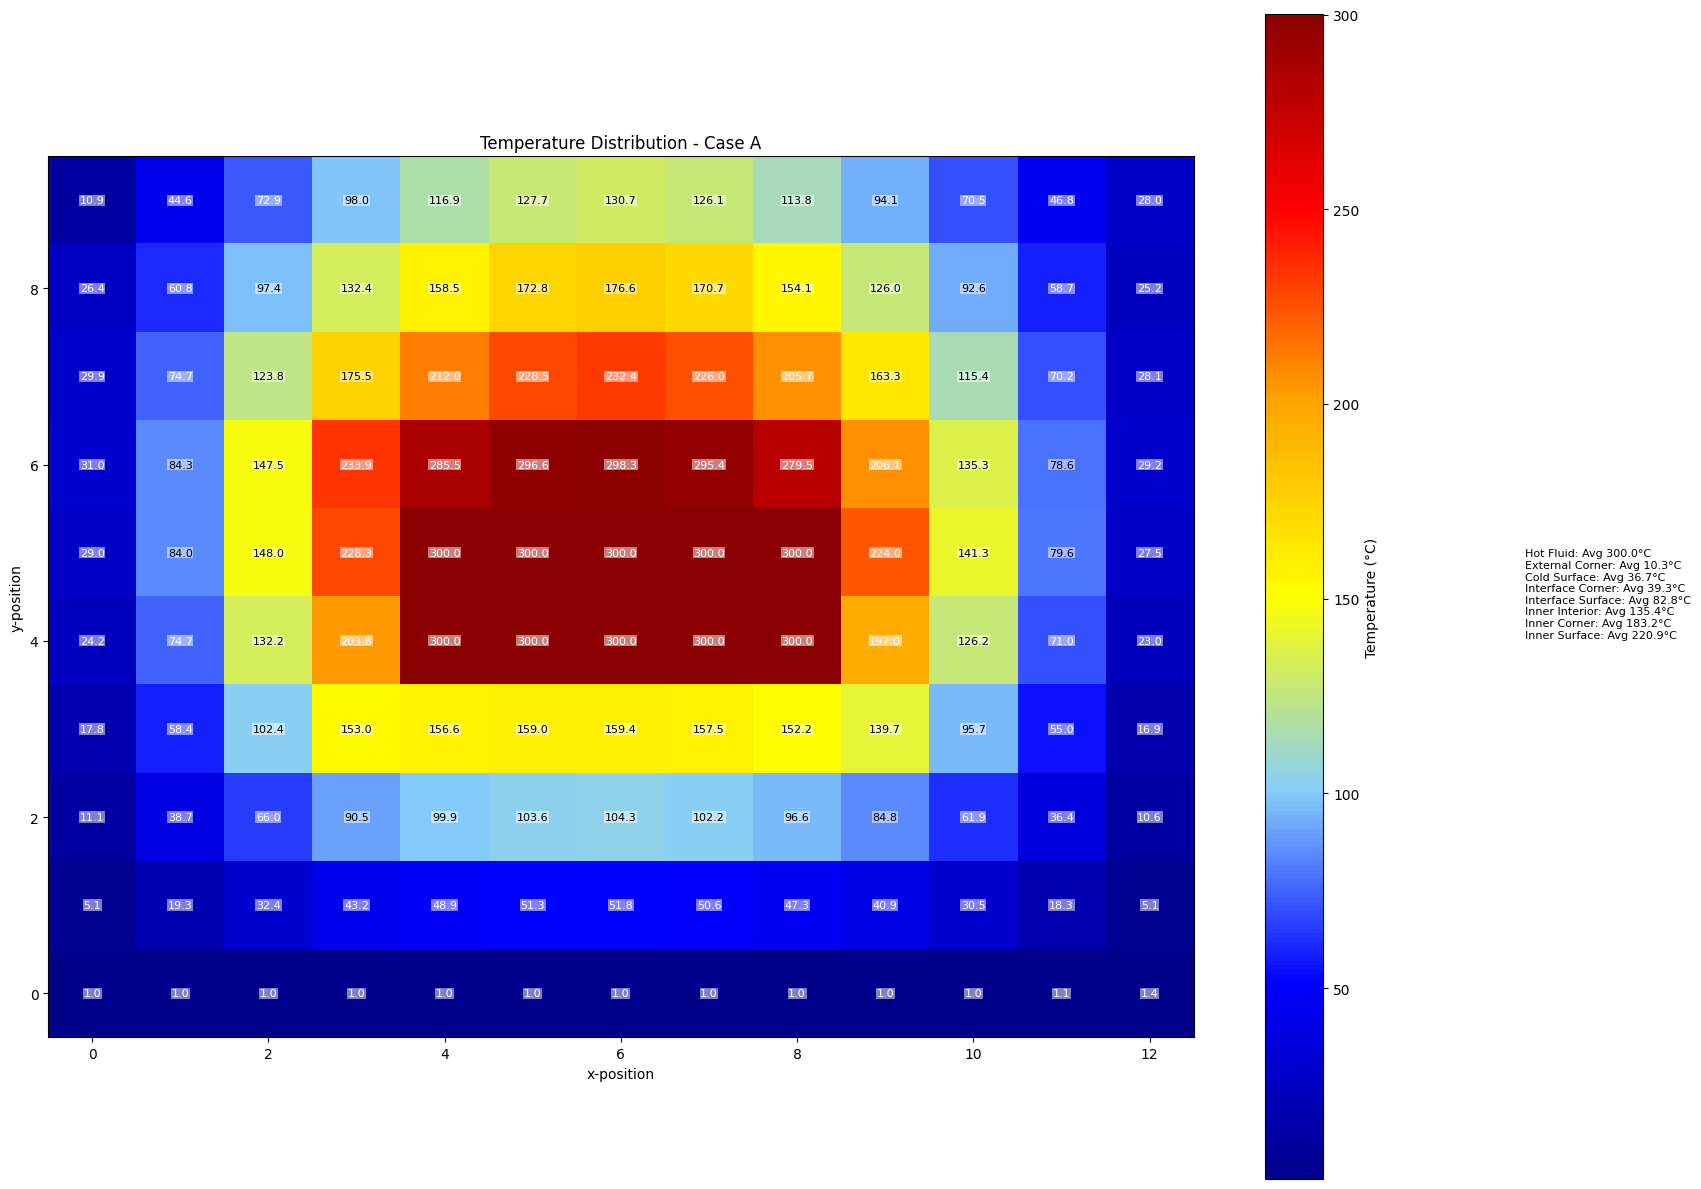

Solving Case B...


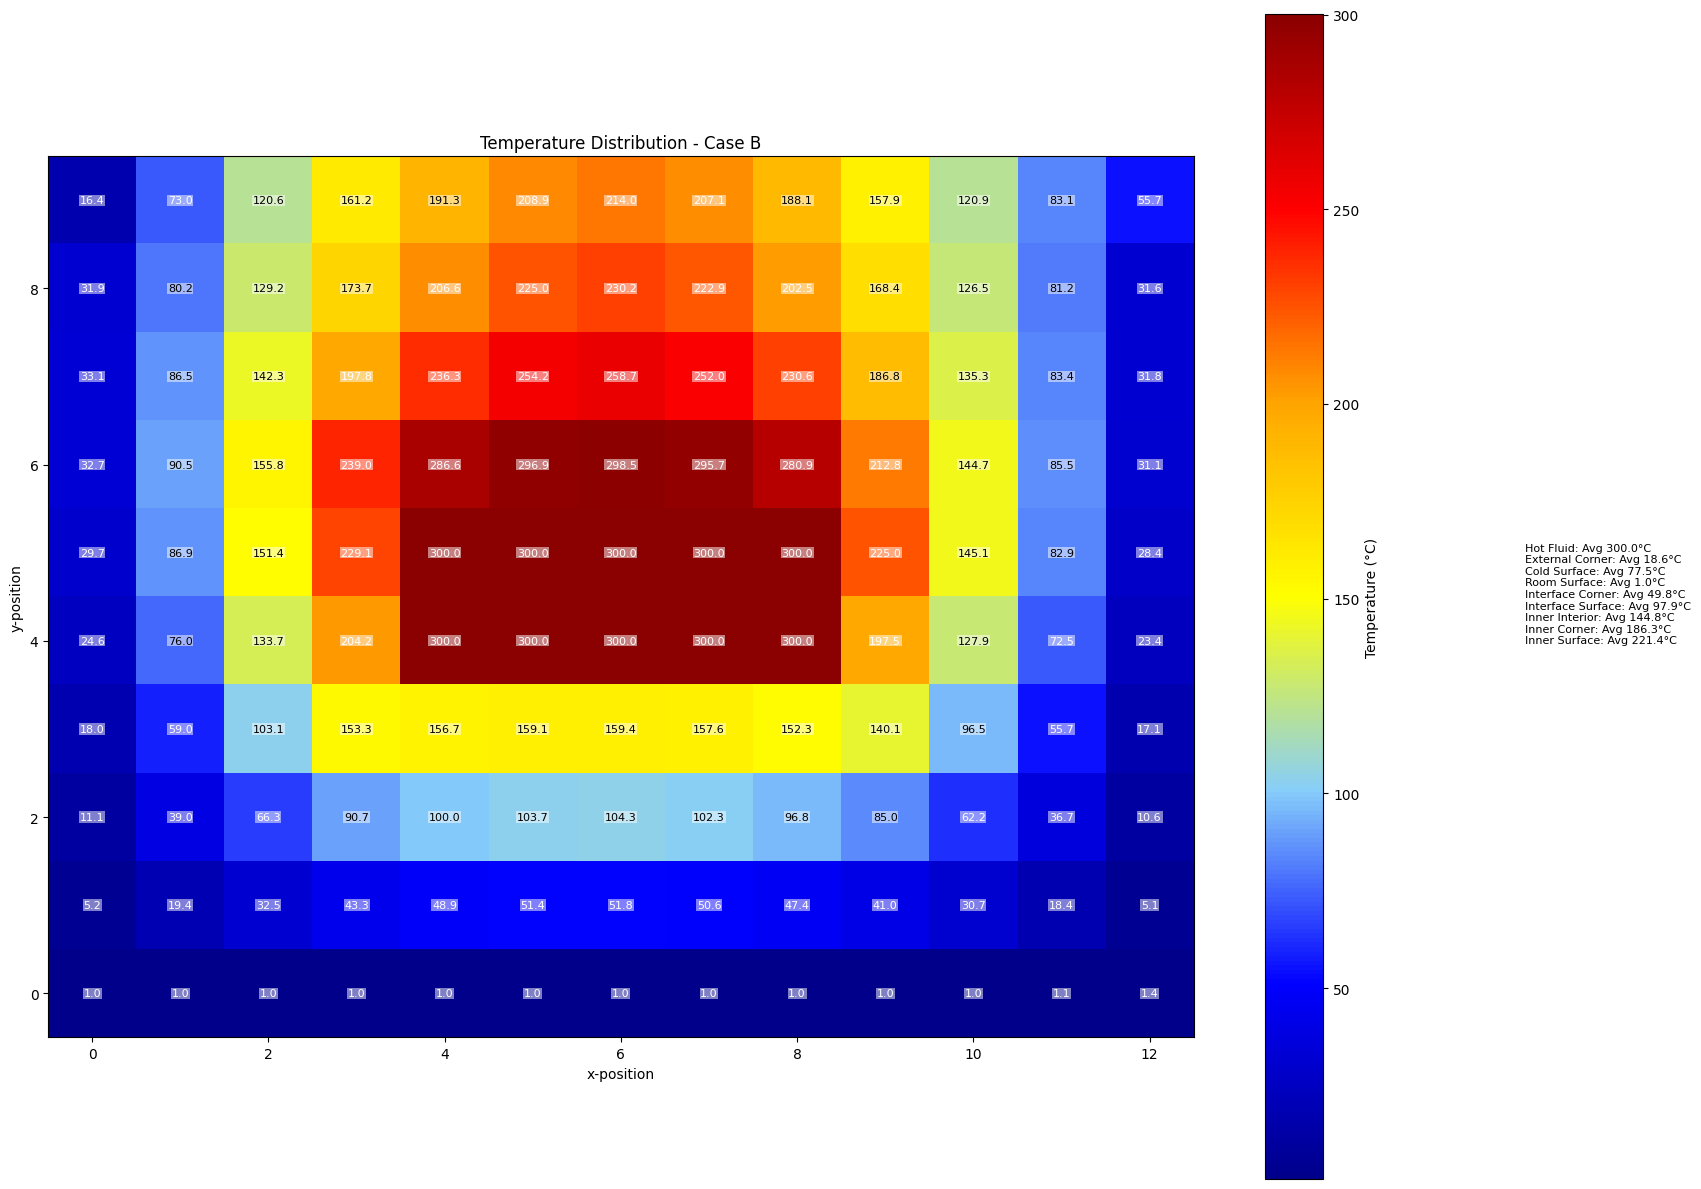

In [5]:
import numpy as np
from scipy.sparse import lil_matrix, csc_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
from enum import Enum
from typing import List, Tuple, Set
from matplotlib.colors import LinearSegmentedColormap

class NodeType(Enum):
    HOT_FLUID = 0          # Hot fluid region
    EXTERNAL_CORNER = 1    # External corners
    COLD_SURFACE = 2       # Cold surface boundaries
    ROOM_SURFACE = 3       # Room temperature surface
    INTERFACE_CORNER = 4   # Corners at interfaces
    INTERFACE_SURFACE = 5  # Surface between materials
    INNER_INTERIOR = 6     # Interior nodes of inner material
    INNER_CORNER = 7       # Inner corners near hot fluid
    INNER_SURFACE = 9      # Inner surface near hot fluid


def create_refined_grid(coarse_grid, refinement_factor):
    """Create a refined grid from a coarse grid pattern"""
    ny, nx = coarse_grid.shape
    refined_ny = (ny-1) * refinement_factor + 1
    refined_nx = (nx-1) * refinement_factor + 1
    refined_grid = np.zeros((refined_ny, refined_nx), dtype=int)
    
    # First, copy existing points
    for i in range(ny):
        for j in range(nx):
            refined_i = i * refinement_factor
            refined_j = j * refinement_factor
            refined_grid[refined_i, refined_j] = coarse_grid[i, j]
    
    # Then interpolate between points
    # Horizontal interpolation
    for i in range(0, refined_ny, refinement_factor):
        for j in range(0, refined_nx-1, refinement_factor):
            start_type = refined_grid[i, j]
            end_type = refined_grid[i, j+refinement_factor]
            for k in range(1, refinement_factor):
                refined_grid[i, j+k] = start_type
                
    # Vertical interpolation
    for j in range(refined_nx):
        for i in range(0, refined_ny-1, refinement_factor):
            start_type = refined_grid[i, j]
            end_type = refined_grid[i+refinement_factor, j]
            for k in range(1, refinement_factor):
                refined_grid[i+k, j] = start_type
                
    return refined_grid

class ChimneyAnalysis:
    def __init__(self, nx=13, ny=10, case='a', refinement_factor=1):
        # Thermal properties
        self.T_cold = 4.0
        self.T_room = 24.0
        self.T_hot = 300.0
        self.h_cold = 25.0
        self.h_room = 4.0
        self.h_hot = 90.0
        self.k_inner = 45.0
        self.k_outer = 15.0
        
        # Grid properties
        self.base_nx = nx
        self.base_ny = ny
        self.refinement_factor = refinement_factor
        self.nx = (nx-1) * refinement_factor + 1
        self.ny = (ny-1) * refinement_factor + 1
        self.dx = 0.20 / refinement_factor  # Refined grid spacing
        self.case = case.lower()
        
        # Initialize grids
        base_node_types = self.setup_base_node_types()
        self.node_types = create_refined_grid(base_node_types, refinement_factor)
        
    def setup_base_node_types(self):
        """Setup the base (coarse) node types"""
        if self.case == 'a':
            return np.array([
                [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1],
                [2, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 2],
                [2, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 2],
                [2, 5, 6, 7, 9, 9, 9, 9, 9, 7, 6, 5, 2],
                [2, 5, 6, 9, 0, 0, 0, 0, 0, 9, 6, 5, 2],
                [2, 5, 6, 9, 0, 0, 0, 0, 0, 9, 6, 5, 2],
                [2, 5, 6, 7, 9, 9, 9, 9, 9, 7, 6, 5, 2],
                [2, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 2],
                [2, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 2],
                [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1]
            ])
        else: # case 'b'
            return np.array([
                [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1],
                [2, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 2],
                [2, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 2],
                [2, 5, 6, 7, 9, 9, 9, 9, 9, 7, 6, 5, 2],
                [2, 5, 6, 9, 0, 0, 0, 0, 0, 9, 6, 5, 2],
                [2, 5, 6, 9, 0, 0, 0, 0, 0, 9, 6, 5, 2],
                [2, 5, 6, 7, 9, 9, 9, 9, 9, 7, 6, 5, 2],
                [2, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 2],
                [2, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 2],
                [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1]
            ])
        #     return np.array([
        #     [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1],
        #     [2, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 2],
        #     [2, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 2],
        #     [2, 5, 6, 7, 9, 9, 9, 9, 9, 7, 6, 5, 2],
        #     [2, 5, 6, 9, 0, 0, 0, 0, 0, 9, 6, 5, 2],
        #     [2, 5, 6, 9, 0, 0, 0, 0, 0, 9, 6, 5, 2],
        #     [2, 5, 6, 7, 9, 9, 9, 9, 9, 7, 6, 5, 2],
        #     [2, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 2],
        #     [2, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 2],
        #     [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1]
        # ])

    def get_node_number(self, i: int, j: int) -> int:
        """Convert 2D indices to node number."""
        return i * self.nx + j
    
    def get_convection_params(self, i: int, j: int) -> Tuple[float, float]:
        """Get convection parameters (h, T_inf) based on position and case"""
        if self.case == 'b' and i == self.ny-1:  # Top surface for case B
            return self.h_room, self.T_room
        return self.h_cold, self.T_cold
    
    def set_node_equations(self, A, b, i, j):
        """Set equations for node based on its type using exact finite difference equations"""
        node_type = self.node_types[i,j]
        node = self.get_node_number(i, j)
        dx = self.dx
        
        # Hot fluid nodes
        if node_type == NodeType.HOT_FLUID.value:
            A[node, node] = 1
            b[node] = self.T_hot
            return
        
        # Get all possible neighbor positions
        neighbors = {
            'n': (i-1, j),   # north
            's': (i+1, j),   # south
            'e': (i, j+1),   # east
            'w': (i, j-1)    # west
        }
        
        # Filter valid neighbors
        valid_neighbors = {
            dir: pos for dir, pos in neighbors.items() 
            if 0 <= pos[0] < self.ny and 0 <= pos[1] < self.nx
        }
                
        if node_type == NodeType.INNER_CORNER.value:
            # Equation 4.41: Node at an internal corner with convection
            k = self.k_inner
            h = self.h_hot
            
            # 2(T_{m-1,n} + T_{m,n+1}) + (T_{m+1,n} + T_{m,n-1})
            for dir, (ni, nj) in valid_neighbors.items():
                if dir in ['n', 'e']:  # north and east neighbors get coefficient of 2
                    A[node, self.get_node_number(ni, nj)] = 2
                else:  # south and west neighbors get coefficient of 1
                    A[node, self.get_node_number(ni, nj)] = 1
                    
            A[node, node] = -2 * (3 + h * dx / k)
            b[node] = -2 * h * dx * self.T_hot / k
            
        # elif node_type == NodeType.INNER_SURFACE.value:
        #     # Equation 4.42: Node at a plane surface with convection (inner)
        #     k = self.k_inner
        #     h = self.h_hot
            
        #     # Check which direction has hot fluid to determine orientation
        #     has_hot_fluid = {
        #         'n': (i-1 >= 0 and self.node_types[i-1,j] == NodeType.HOT_FLUID.value),
        #         's': (i+1 < self.ny and self.node_types[i+1,j] == NodeType.HOT_FLUID.value),
        #         'e': (j+1 < self.nx and self.node_types[i,j+1] == NodeType.HOT_FLUID.value),
        #         'w': (j-1 >= 0 and self.node_types[i,j-1] == NodeType.HOT_FLUID.value)
        #     }
            
        #     # Determine surface orientation based on hot fluid location
        #     if has_hot_fluid['n']:      # Bottom surface of hot fluid
        #         double_coef_dir = 's'    # Double coefficient for south neighbor
        #         single_coef_dirs = ['e', 'w']  # Single coefficient for east and west
        #     elif has_hot_fluid['s']:    # Top surface of hot fluid
        #         double_coef_dir = 'n'    # Double coefficient for north neighbor
        #         single_coef_dirs = ['e', 'w']
        #     elif has_hot_fluid['e']:    # Left surface of hot fluid
        #         double_coef_dir = 'w'    # Double coefficient for west neighbor
        #         single_coef_dirs = ['n', 's']
        #     elif has_hot_fluid['w']:    # Right surface of hot fluid
        #         double_coef_dir = 'e'    # Double coefficient for east neighbor
        #         single_coef_dirs = ['n', 's']
        #     else:
        #         raise ValueError(f"INNER_SURFACE node at ({i}, {j}) not adjacent to hot fluid")
            
        #     # Apply coefficients based on orientation
        #     for dir, (ni, nj) in valid_neighbors.items():
        #         neighbor_node = self.get_node_number(ni, nj)
        #         if dir == double_coef_dir:
        #             A[node, neighbor_node] = 2/k  # Double coefficient for direction opposite to hot fluid
        #         elif dir in single_coef_dirs:
        #             A[node, neighbor_node] = 1/k  # Single coefficient for parallel directions
        
        #     # Central node coefficient and RHS remain the same for all orientations
        #     A[node, node] = -2 * (h * dx / k + 2) / k
        #     b[node] = -2 * h * dx * self.T_hot / k

        elif node_type == NodeType.INNER_SURFACE.value:
            # Equation 4.42: Node at a plane surface with convection (inner)
            k = self.k_inner
            h = self.h_hot
            
            for dir, (ni, nj) in valid_neighbors.items():
                if dir == 'n':  # north neighbor gets coefficient of 2
                    A[node, self.get_node_number(ni, nj)] = 2
                elif dir in ['e', 'w']:  # east and west neighbors get coefficient of 1
                    A[node, self.get_node_number(ni, nj)] = 1
                    
            A[node, node] = -2 * (((h * dx) / k) + 2)
            b[node] = -2 * h * dx * self.T_hot / k
            
        elif node_type in [NodeType.COLD_SURFACE.value, NodeType.ROOM_SURFACE.value]:
            # Equation 4.42: Node at a plane surface with convection (outer)
            k = self.k_outer
            h, T_inf = self.get_convection_params(i, j)
            
            for dir, (ni, nj) in valid_neighbors.items():
                if dir == 'n':  # north neighbor gets coefficient of 2
                    A[node, self.get_node_number(ni, nj)] = 2
                elif dir in ['e', 'w']:  # east and west neighbors get coefficient of 1
                    A[node, self.get_node_number(ni, nj)] = 1
                    
            A[node, node] = -2 * (h * dx / k + 2)
            b[node] = -2 * h * dx * T_inf / k
            
        elif node_type == NodeType.EXTERNAL_CORNER.value:
            # Equation 4.43: Node at an external corner with convection
            k = self.k_outer
            h, T_inf = self.get_convection_params(i, j)
            
            # (T_{m,n-1} + T_{m-1,n})
            for dir, (ni, nj) in valid_neighbors.items():
                if dir in ['n', 'w']:  # north and west neighbors
                    A[node, self.get_node_number(ni, nj)] = 1
                    
            A[node, node] = -2 * (h * dx / k + 1)
            b[node] = -2 * h * dx * T_inf / k
            
        elif node_type == NodeType.INNER_INTERIOR.value:
            # Standard 5-point stencil for interior nodes
            k = self.k_inner
            A[node, node] = -4 * k / (dx * dx)
            for _, (ni, nj) in valid_neighbors.items():
                A[node, self.get_node_number(ni, nj)] = k / (dx * dx)
                
        elif node_type in [NodeType.INTERFACE_CORNER.value, NodeType.INTERFACE_SURFACE.value]:
            # Interface nodes using harmonic mean of conductivities
            k_harmonic = 2 * self.k_inner * self.k_outer / (self.k_inner + self.k_outer)
            A[node, node] = -4 * k_harmonic / (dx * dx)
            for _, (ni, nj) in valid_neighbors.items():
                A[node, self.get_node_number(ni, nj)] = k_harmonic / (dx * dx)

    def create_system(self):
        """Create the system matrix and RHS vector."""
        n = self.nx * self.ny
        A = lil_matrix((n, n))
        b = np.zeros(n)
        
        for i in range(self.ny):
            for j in range(self.nx):
                self.set_node_equations(A, b, i, j)
        
        return csc_matrix(A), b

    def solve(self):
        """Solve the system for temperature distribution."""
        A, b = self.create_system()
        T = spsolve(A, b)
        return T.reshape((self.ny, self.nx))

    def plot_solution(self, T):
        """Plot the temperature distribution with node temperatures displayed."""
        plt.figure(figsize=(15, 12))
        
        # Create custom colormap: blue -> light blue -> yellow -> orange -> red
        colors = ['darkblue', 'blue', 'lightskyblue', 'yellow', 'orange', 'red', 'darkred']
        n_bins = 256  # Number of color gradations
        custom_cmap = LinearSegmentedColormap.from_list("custom", colors, N=n_bins)
        
        # Plot temperature distribution
        im = plt.imshow(T, cmap=custom_cmap, origin='lower')
        plt.colorbar(im, label='Temperature (°C)')
        plt.title(f'Temperature Distribution - Case {self.case.upper()}')
        
        # Add temperature values as text
        for i in range(self.ny):
            for j in range(self.nx):
                temp_value = T[i, j]
                text = f'{temp_value:.1f}'
                # Adjust text color based on normalized temperature
                temp_norm = (temp_value - T.min()) / (T.max() - T.min())
                # Use black text for light colors (light blue, yellow) and white for dark colors
                text_color = 'black' if 0.25 < temp_norm < 0.65 else 'white'
                
                plt.text(j, i, text, ha='center', va='center', 
                        color=text_color, fontsize=8, 
                        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=0.5))
        
        plt.xlabel('x-position')
        plt.ylabel('y-position')
        
        # Add node type legend with average temperatures
        node_types = {
            'Hot Fluid': 0,
            'External Corner': 1,
            'Cold Surface': 2,
            'Room Surface': 3,
            'Interface Corner': 4,
            'Interface Surface': 5,
            'Inner Interior': 6,
            'Inner Corner': 7,
            'Inner Surface': 9
        }
        
        # Create legend entries
        legend_elements = []
        for name, value in node_types.items():
            mask = self.node_types == value
            if np.any(mask):
                avg_temp = np.mean(T[mask])
                legend_elements.append(f'{name}: Avg {avg_temp:.1f}°C')
        
        plt.figtext(1.02, 0.5, '\n'.join(legend_elements), 
                    fontsize=8, va='center')
        
        plt.tight_layout()
        plt.show()

# Test Case A
print("Solving Case A...")
solver_a = ChimneyAnalysis(case='a')
T_a = solver_a.solve()
solver_a.plot_solution(T_a)

# Test Case B
print("Solving Case B...")
solver_b = ChimneyAnalysis(case='b')
T_b = solver_b.solve()
solver_b.plot_solution(T_b)



Solving Case A...


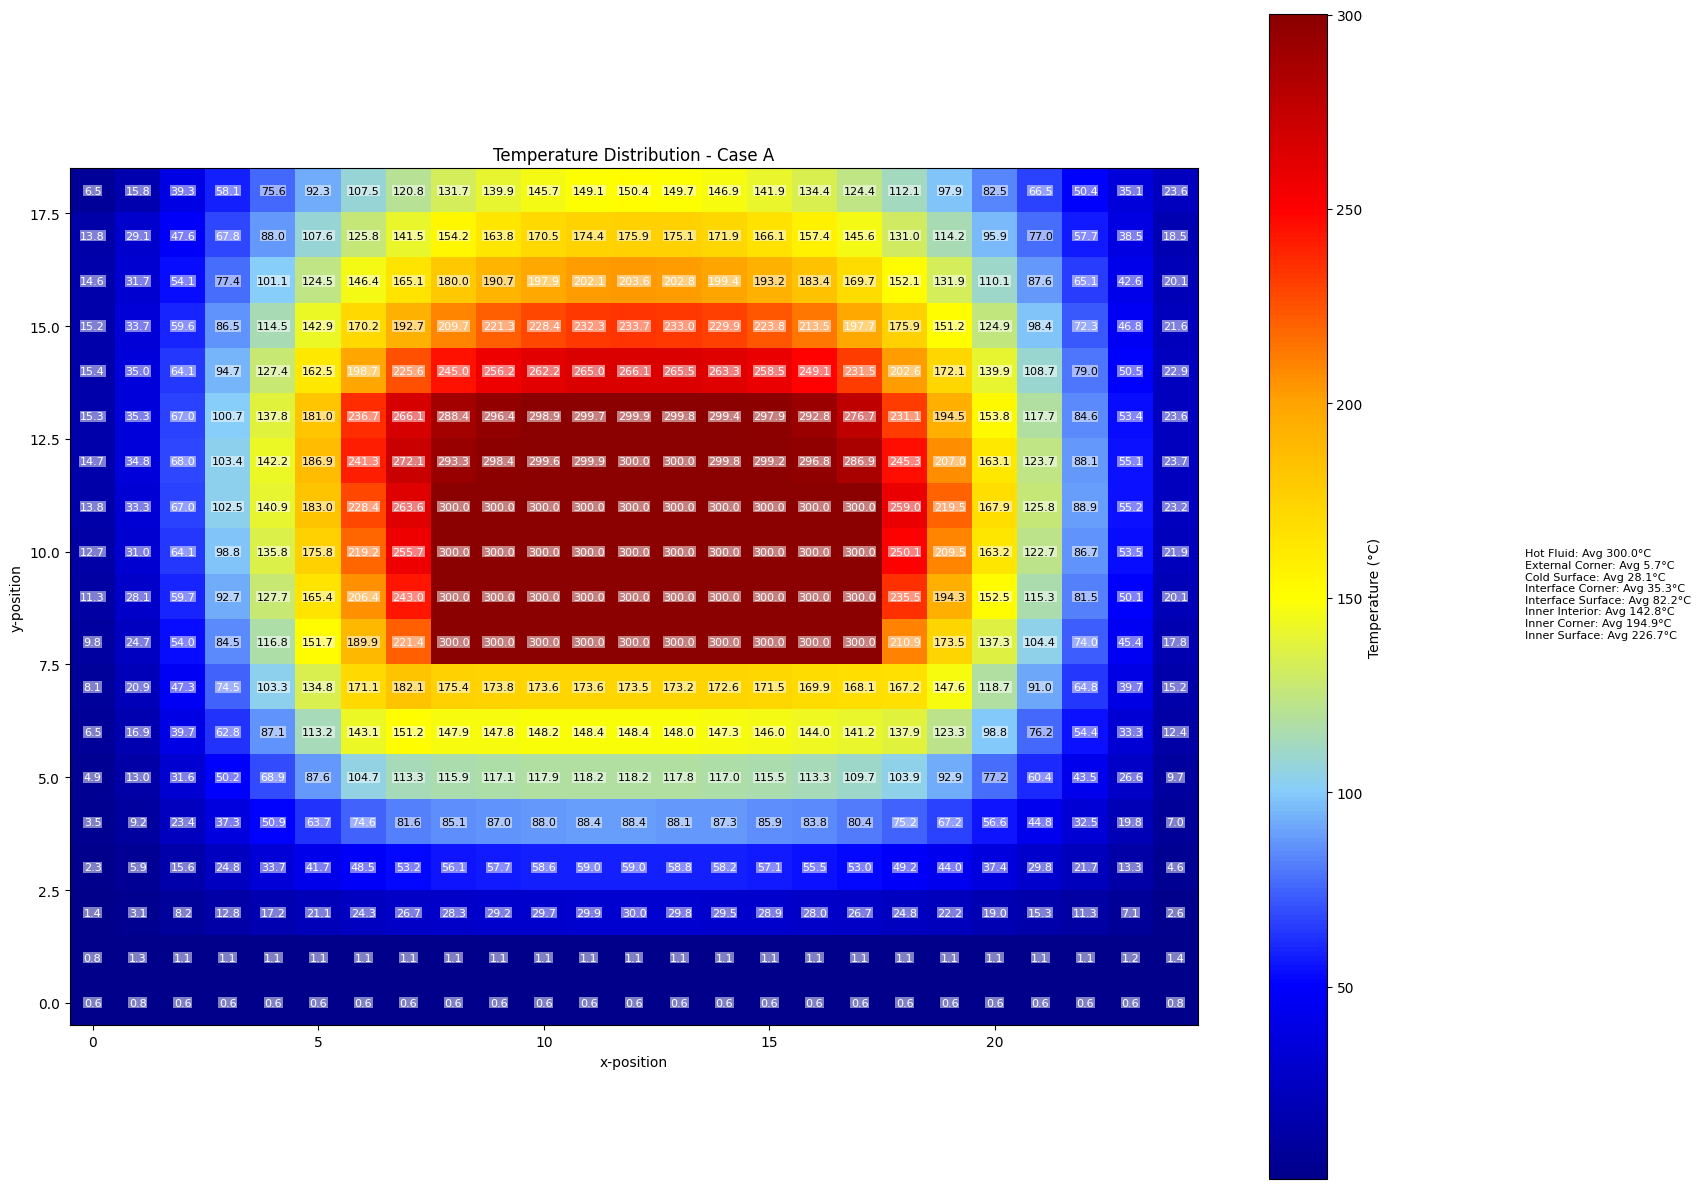

In [11]:
print("Solving Case A...")
solver_a = ChimneyAnalysis(case='a',refinement_factor=2)
T_a = solver_a.solve()
solver_a.plot_solution(T_a)


Solving Case A...
base_node_type:
 [[1 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 5 0 0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 8 0 0 0 0 0 8 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 8 0 0 0 0 0 8 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0 0 5 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 1]]
node_types:
 [[1 2 2 ... 2 2 1]
 [2 4 4 ... 4 4 2]
 [2 4 4 ... 4 4 2]
 ...
 [2 4 4 ... 4 4 2]
 [2 4 4 ... 4 4 2]
 [1 2 2 ... 2 2 1]]
node matrix shape:
 (28, 37)
Grid size: 37x28
Spacing: 0.06666666666666667m
Case: a
Processing node at (0,27) - Type: EXTERNAL_CORNER
  Valid neighbors: {'s': (0, 26), 'e': (1, 27)}
Processing node at (1,27) - Type: COLD_SURFACE
  Valid neighbors: {'s': (1, 26), 'e': (2, 27), 'w': (0, 27)}
Processing node at (2,27) - Type: COLD_SURFACE
  Valid neighbors: {'s': (2, 26), 'e': (3, 27), 'w': (1, 27)}
Processing node at (3,27) - Type: COLD_SURFACE
  Valid neighbors: {'s': (3, 26), 'e': (4, 27), 'w': (2, 27)}
Processing node at (4,27) - Typ

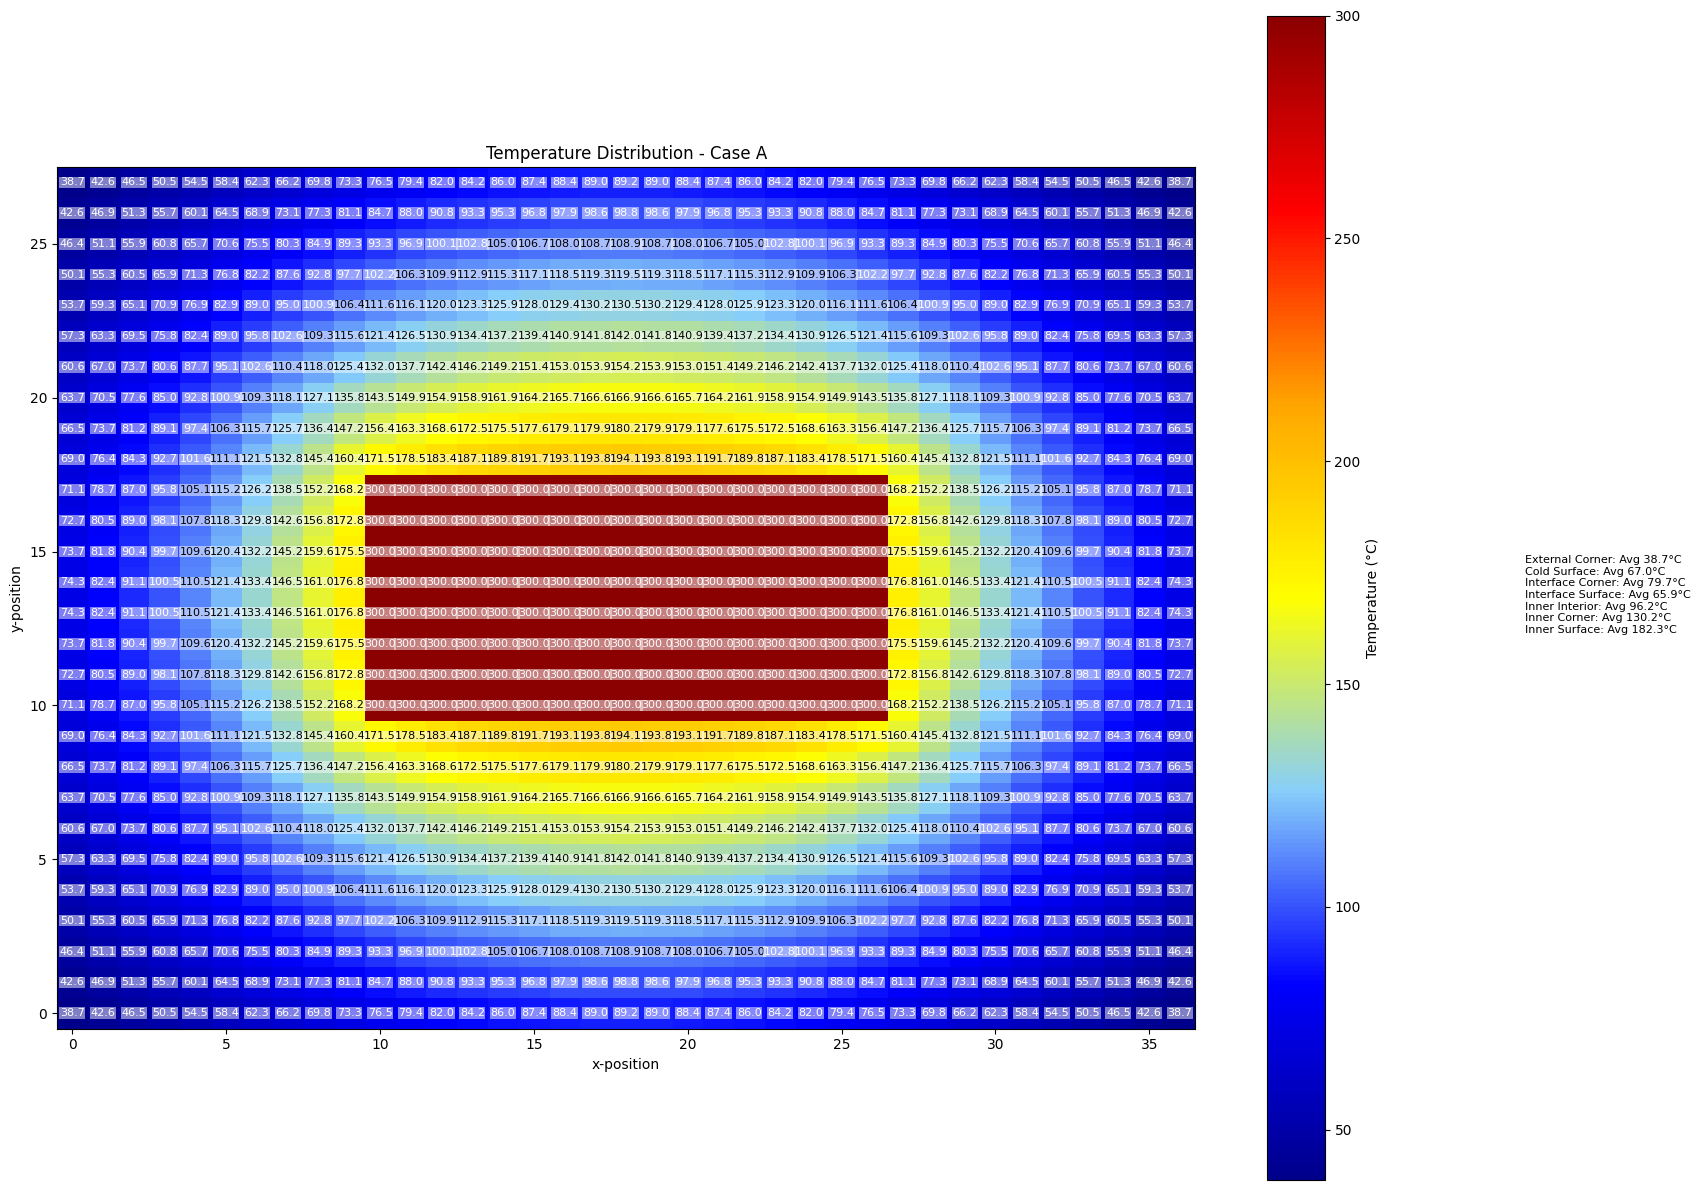


Solving Case B...
base_node_type:
 [[1 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 5 0 0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 8 0 0 0 0 0 8 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 8 0 0 0 0 0 8 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0 0 5 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 1]]
node_types:
 [[1 2 2 ... 2 2 1]
 [2 4 4 ... 4 4 2]
 [2 4 4 ... 4 4 2]
 ...
 [2 4 4 ... 4 4 2]
 [2 4 4 ... 4 4 2]
 [1 2 2 ... 2 2 1]]
node matrix shape:
 (28, 37)
Grid size: 37x28
Spacing: 0.06666666666666667m
Case: b
Processing node at (0,27) - Type: EXTERNAL_CORNER
  Valid neighbors: {'s': (0, 26), 'e': (1, 27)}
Processing node at (1,27) - Type: COLD_SURFACE
  Valid neighbors: {'s': (1, 26), 'e': (2, 27), 'w': (0, 27)}
Processing node at (2,27) - Type: COLD_SURFACE
  Valid neighbors: {'s': (2, 26), 'e': (3, 27), 'w': (1, 27)}
Processing node at (3,27) - Type: COLD_SURFACE
  Valid neighbors: {'s': (3, 26), 'e': (4, 27), 'w': (2, 27)}
Processing node at (4,27) - Typ

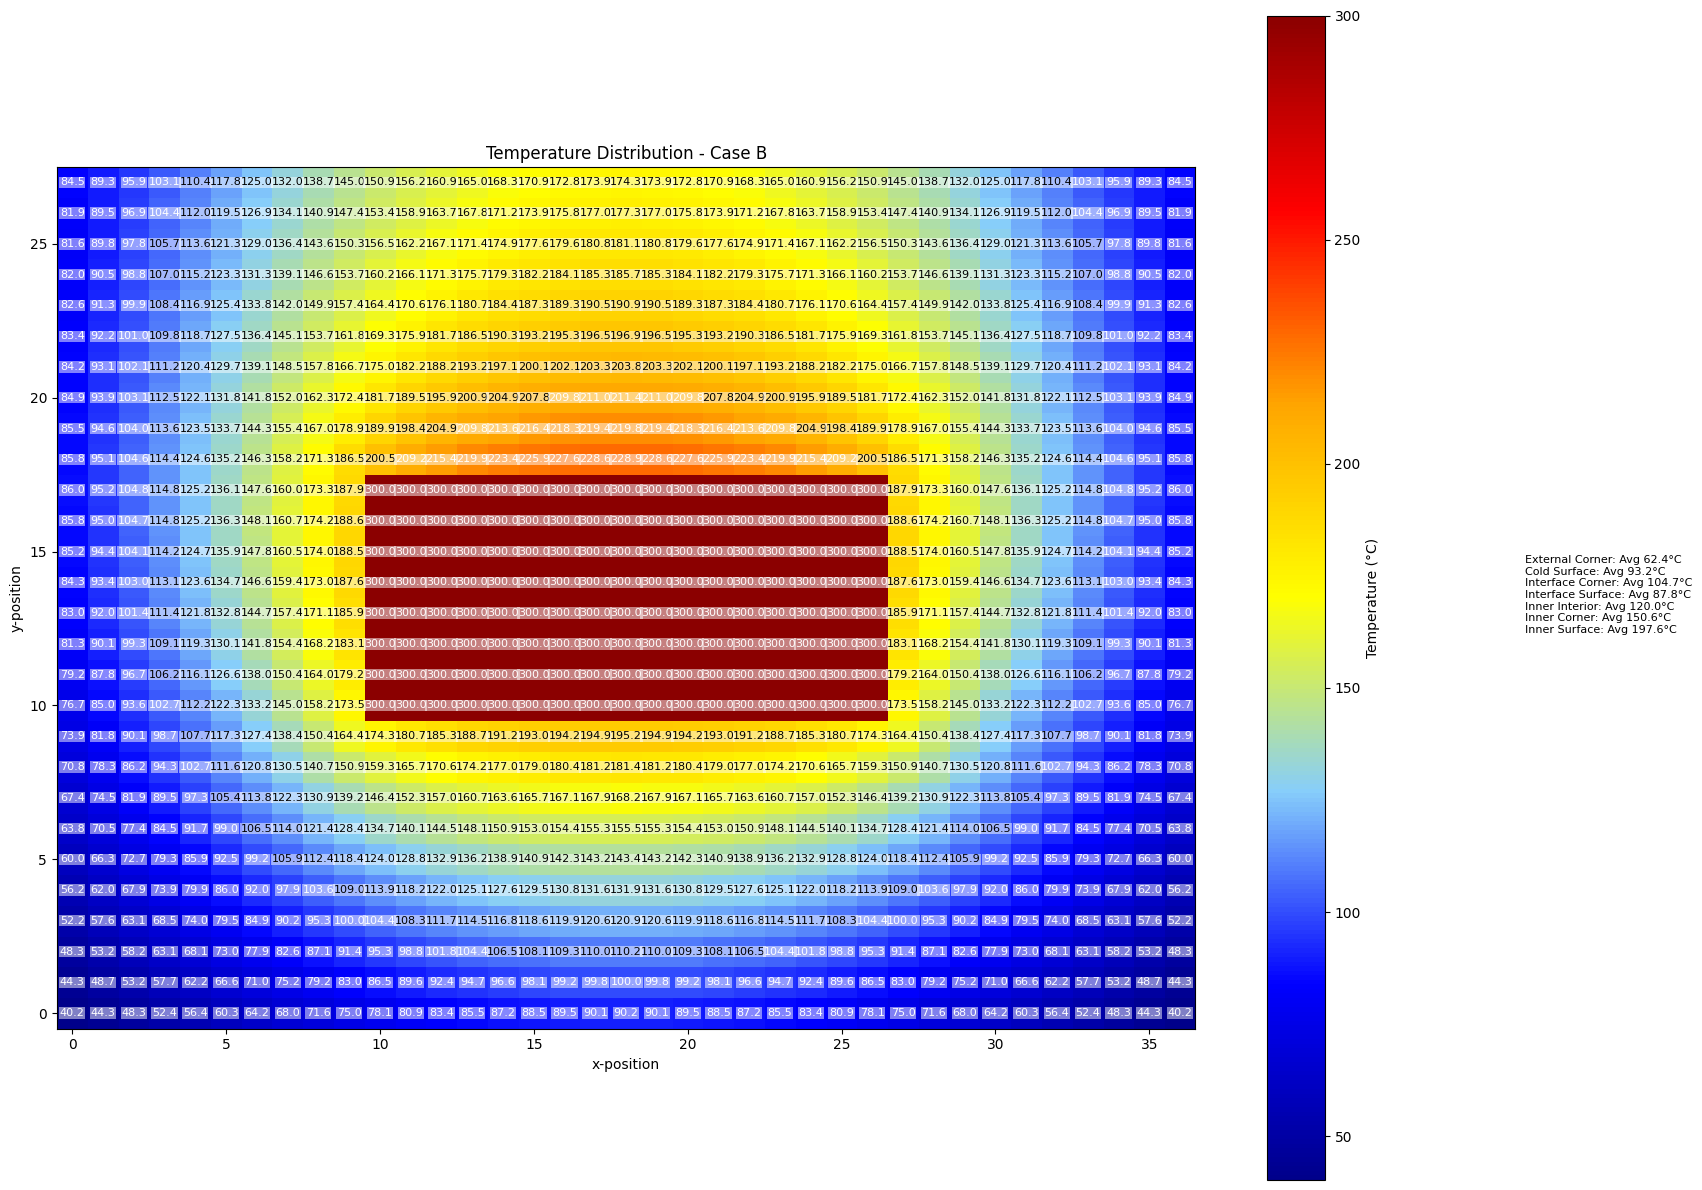

In [33]:
class NodeType(Enum):
    HOT_FLUID = -1
    EXTERNAL_CORNER = 1
    COLD_SURFACE = 2
    ROOM_SURFACE = 3
    OUTER_INTERIOR = 4
    INTERFACE_CORNER = 5
    INTERFACE_SURFACE = 6
    INNER_INTERIOR = 7
    INNER_CORNER = 8
    INNER_SURFACE = 9



class ChimneyAnalysis:
    def __init__(self, nx=13, ny=10, case='a', refinement_factor=1, grid_size=0.2):
        # Thermal properties
        self.T_cold = 4.0
        self.T_room = 24.0
        self.T_hot = 300.0
        self.h_cold = 25.0
        self.h_room = 4.0
        self.h_hot = 90.0
        self.k_inner = 45.0
        self.k_outer = 15.0
        
        # Grid properties
        self.base_nx = nx
        self.base_ny = ny
        self.refinement_factor = refinement_factor
        self.nx = (nx-1) * refinement_factor + 1
        self.ny = (ny-1) * refinement_factor + 1
        self.dx = grid_size / refinement_factor
        self.case = case.lower()
        
        # initialize grids
        base_node_types = self.setup_base_node_types()
        self.node_types = self.create_refined_grid(base_node_types, refinement_factor)
    
    def create_refined_grid(self, coarse_grid, refinement_factor=2):
        """Create a refined grid by first placing corners, then filling surfaces between them then filling the regions"""
        ny, nx = coarse_grid.shape
        refined_ny = (ny-1) * refinement_factor + 1
        refined_nx = (nx-1) * refinement_factor + 1
        refined_grid = np.zeros((refined_ny, refined_nx), dtype=int)
        
        # Step 1: Map corner points to their new positions in refined grid
        corner_mapping = {}  # Store original corner positions and their new positions
        for i in range(ny):
            for j in range(nx):
                if coarse_grid[i, j] in [NodeType.EXTERNAL_CORNER.value, 
                                    NodeType.INTERFACE_CORNER.value,
                                    NodeType.INNER_CORNER.value]:
                    # Calculate new position in refined grid
                    refined_i = i * refinement_factor
                    refined_j = j * refinement_factor
                    refined_grid[refined_i, refined_j] = coarse_grid[i, j]
                    corner_mapping[(i, j)] = (refined_i, refined_j)
        
        # Step 2: Fill surfaces between corners
        def fill_between(pos1, pos2, node_type):
            y1, x1 = pos1
            y2, x2 = pos2
            # If horizontal line
            if y1 == y2:
                for x in range(min(x1, x2) + 1, max(x1, x2)):
                    refined_grid[y1, x] = node_type
            # If vertical line
            elif x1 == x2:
                for y in range(min(y1, y2) + 1, max(y1, y2)):
                    refined_grid[y, x1] = node_type
        
        # Fill external surfaces
        # Get corners for each type
        external_corners = sorted([(i, j) for (i, j), type_val in corner_mapping.items() 
                                if coarse_grid[i, j] == NodeType.EXTERNAL_CORNER.value])
        interface_corners = sorted([(i, j) for (i, j), type_val in corner_mapping.items() 
                                if coarse_grid[i, j] == NodeType.INTERFACE_CORNER.value])
        inner_corners = sorted([(i, j) for (i, j), type_val in corner_mapping.items() 
                            if coarse_grid[i, j] == NodeType.INNER_CORNER.value])
        
        # Connect corners with surfaces
        for i in range(len(external_corners)):
            curr_corner = external_corners[i]
            for next_corner in external_corners[i+1:]:
                if curr_corner[0] == next_corner[0] or curr_corner[1] == next_corner[1]:
                    fill_between(corner_mapping[curr_corner], corner_mapping[next_corner], 
                            NodeType.COLD_SURFACE.value)
        
        for i in range(len(interface_corners)):
            curr_corner = interface_corners[i]
            for next_corner in interface_corners[i+1:]:
                if curr_corner[0] == next_corner[0] or curr_corner[1] == next_corner[1]:
                    fill_between(corner_mapping[curr_corner], corner_mapping[next_corner], 
                            NodeType.INTERFACE_SURFACE.value)
        
        for i in range(len(inner_corners)):
            curr_corner = inner_corners[i]
            for next_corner in inner_corners[i+1:]:
                if curr_corner[0] == next_corner[0] or curr_corner[1] == next_corner[1]:
                    fill_between(corner_mapping[curr_corner], corner_mapping[next_corner], 
                            NodeType.INNER_SURFACE.value)
        
        # Step 3: Fill regions
        # Get boundary coordinates for each region
        inner_y_min = min(corner_mapping[c][0] for c in inner_corners)
        inner_y_max = max(corner_mapping[c][0] for c in inner_corners)
        inner_x_min = min(corner_mapping[c][1] for c in inner_corners)
        inner_x_max = max(corner_mapping[c][1] for c in inner_corners)
        
        interface_y_min = min(corner_mapping[c][0] for c in interface_corners)
        interface_y_max = max(corner_mapping[c][0] for c in interface_corners)
        interface_x_min = min(corner_mapping[c][1] for c in interface_corners)
        interface_x_max = max(corner_mapping[c][1] for c in interface_corners)
        
        # Fill HOT_FLUID region (inside inner corners)
        for y in range(inner_y_min + 1, inner_y_max):
            for x in range(inner_x_min + 1, inner_x_max):
                if refined_grid[y, x] == 0:
                    refined_grid[y, x] = NodeType.HOT_FLUID.value
        
        # Fill INNER_INTERIOR region (between interface corners but not in HOT_FLUID)
        for y in range(interface_y_min + 1, interface_y_max):
            for x in range(interface_x_min + 1, interface_x_max):
                if refined_grid[y, x] == 0:  # Only fill zeros
                    refined_grid[y, x] = NodeType.INNER_INTERIOR.value
        
        # Fill OUTER_INTERIOR (any remaining zeros)
        for y in range(refined_ny):
            for x in range(refined_nx):
                if refined_grid[y, x] == 0:
                    refined_grid[y, x] = NodeType.OUTER_INTERIOR.value
        
        return refined_grid

    def setup_base_node_types(self):
        """Setup grid with just corner positions defined"""
        # Initialize empty grid
        base = np.zeros((self.base_ny, self.base_nx), dtype=int)
        
        external_corners = [
            (0, 0),
            (0, -1),
            (-1, 0),
            (-1, -1)
        ]
        
        interface_corners = [
            (1, 1),
            (1, -2),
            (-2, 1),
            (-2, -2)
        ]
        
        inner_corners = [
            (3, 3),
            (3, -4),
            (-4, 3),
            (-4, -4)
        ]
        
        for x, y in external_corners:
            base[y, x] = NodeType.EXTERNAL_CORNER.value
            
        for x, y in interface_corners:
            base[y, x] = NodeType.INTERFACE_CORNER.value
            
        for x, y in inner_corners:
            base[y, x] = NodeType.INNER_CORNER.value
        
        return base

    def get_node_number(self, x: int, y: int) -> int:
        """Convert x,y coordinates to node number.
        x: horizontal position (0 to nx-1)
        y: vertical position (0 to ny-1)"""
        return y * self.nx + x

    def get_convection_params(self, x: int, y: int) -> Tuple[float, float]:
        """Get convection parameters (h, T_inf) based on position and case.
        Parameters based on physical position (bottom-left origin)"""
        if self.case == 'b' and y == self.ny-1:  # Top surface for case B
            return self.h_room, self.T_room
        return self.h_cold, self.T_cold

    def get_corner_type(self, x: int, y: int) -> str:
        """Determine corner type based on position"""
        node_type = self.node_types[self.ny-1-y, x]  # Convert to array indices
        if node_type != NodeType.EXTERNAL_CORNER.value:
            return None

        is_left = (x == 0)
        is_right = (x == self.nx-1)
        is_bottom = (y == 0)
        is_top = (y == self.ny-1)
        
        if is_top and is_right: return 'tr'
        if is_top and is_left: return 'tl'
        if is_bottom and is_right: return 'br'
        if is_bottom and is_left: return 'bl'
        return None
    
    def get_node_type(self, x: int, y: int) -> int:
        """Get node type at physical coordinates (x,y)"""
        # Convert from physical coordinates to array indices
        array_y = self.ny - 1 - y
        return self.node_types[array_y, x]
    
    def get_neighbors(self, x: int, y: int) -> dict:
        """Get valid neighbor coordinates for a given position"""
        # Define all possible neighbors
        neighbors = {
            'n': (x, y+1),    # north: same x, y+1
            's': (x, y-1),    # south: same x, y-1
            'e': (x+1, y),    # east:  x+1, same y
            'w': (x-1, y)     # west:  x-1, same y
        }
        
        # Filter valid neighbors
        return {
            dir: pos for dir, pos in neighbors.items() 
            if 0 <= pos[0] < self.nx and 0 <= pos[1] < self.ny
            and self.get_node_type(pos[0], pos[1]) != NodeType.HOT_FLUID.value
        }

    def has_hot_fluid_neighbor(self, x: int, y: int) -> bool:
        """Check if any neighboring position has hot fluid"""
        neighbor_positions = [
            (x-1, y), (x+1, y),  # left, right
            (x, y-1), (x, y+1)   # below, above
        ]
        return (any(
            0 <= nx < self.nx and 0 <= ny < self.ny and 
            self.get_node_type(nx, ny) == NodeType.HOT_FLUID.value
            for nx, ny in neighbor_positions
        )or self.get_node_type(x,y) == NodeType.INNER_CORNER.value) 

    def set_node_equations(self, A, b, x, y):
        """Set equations for node at position (x,y)"""
        node_type = self.node_types[self.ny-1-y, x]  # Convert to array indices
        node = self.get_node_number(x, y)
        dx = self.dx
        
        print(f"Processing node at ({x},{y}) - Type: {NodeType(node_type).name}")
        
        if node_type == NodeType.HOT_FLUID.value:
            A[node, node] = 1
            b[node] = self.T_hot
            return

        # Get valid neighbors for this node
        neighbors = self.get_neighbors(x, y)
        print(f"  Valid neighbors: {neighbors}")

        # Handle different node types
        if node_type == NodeType.EXTERNAL_CORNER.value:
            k = self.k_outer
            h, T_inf = self.get_convection_params(x, y)
            corner_type = self.get_corner_type(x, y)
            
            # Define appropriate neighbors based on corner type
            if corner_type == 'tr':    valid_dirs = ['w', 's']
            elif corner_type == 'tl':   valid_dirs = ['e', 's']
            elif corner_type == 'br':   valid_dirs = ['w', 'n']
            elif corner_type == 'bl':   valid_dirs = ['e', 'n']
            else: raise ValueError(f"Invalid corner position at ({x},{y})")
            
            # Apply coefficients
            for dir, pos in neighbors.items():
                if dir in valid_dirs:
                    neighbor_node = self.get_node_number(*pos)
                    A[node, neighbor_node] = 1
                    
            A[node, node] = -2 * (((h * dx) / k) + 1)
            b[node] = (-2 * h * dx * T_inf )/ k # RHS term
            
        elif node_type == NodeType.INNER_CORNER.value:
            k = self.k_inner
            h = self.h_hot
            
            # Check which neighbors are hot fluid to determine corner orientation
            has_hot_fluid = {
                    dir: self.has_hot_fluid_neighbor(*pos)
                    for dir, pos in neighbors.items()
                }
            print(f"  Hot fluid neighbors: {has_hot_fluid}")
            
            # Based on equation 4.41: 2(T_{m-1,n} + T_{m,n+1}) + (T_{m+1,n} + T_{m,n-1})
            # For each possible orientation:
            corner_coeffs = {}
            if has_hot_fluid.get('n') and has_hot_fluid.get('e'):  # Hot fluid at north-east
                corner_coeffs = {'s': 2, 'w': 2, 'n': 1, 'e': 1}  # South and west get 2, others 1
            elif has_hot_fluid.get('n') and has_hot_fluid.get('w'):  # Hot fluid at north-west
                corner_coeffs = {'s': 2, 'e': 2, 'n': 1, 'w': 1}
            elif has_hot_fluid.get('s') and has_hot_fluid.get('e'):  # Hot fluid at south-east
                corner_coeffs = {'n': 2, 'w': 2, 's': 1, 'e': 1}
            elif has_hot_fluid.get('s') and has_hot_fluid.get('w'):  # Hot fluid at south-west
                corner_coeffs = {'n': 2, 'e': 2, 's': 1, 'w': 1}
            else:
                raise ValueError(f"Inner corner at ({x},{y}) not properly adjacent to hot fluid")
                
            print(f"  Corner coefficients: {corner_coeffs}")
            
            # Apply coefficients to neighbors
            for dir, pos in neighbors.items():
                neighbor_node = self.get_node_number(*pos)
                if dir in corner_coeffs:
                    A[node, neighbor_node] = corner_coeffs[dir]
                    
            # Central node coefficient: -2(3 + h∆x/k)
            A[node, node] = -2 * (3 + ((h * dx) / k))
            
            # Right hand side term: 2(h∆x/k)T_∞
            b[node] = (-2 * h * dx * self.T_hot) / k
            
        elif node_type == NodeType.INNER_SURFACE.value:
            k = self.k_inner
            h = self.h_hot
            
            # All possible directions
            all_dirs = {'n', 's', 'e', 'w'}
            # Get missing direction (this will be where hot fluid is)
            hot_dir = next(dir for dir in all_dirs if dir not in neighbors.keys())
            print(f"  Hot fluid direction (missing from neighbors): {hot_dir}")
            
            # Opposite direction to hot fluid gets double coefficient
            double_coef_dir = {
                'n': 's',
                's': 'n',
                'e': 'w',
                'w': 'e'
            }[hot_dir]
            
            # Parallel directions (perpendicular to hot fluid direction)
            single_coef_dirs = ['n', 's'] if hot_dir in ['e', 'w'] else ['e', 'w']
            
            print(f"  Double coef dir: {double_coef_dir}, Single coef dirs: {single_coef_dirs}")
            
            # Apply coefficients to existing neighbors
            for dir, pos in neighbors.items():
                neighbor_node = self.get_node_number(*pos)
                if dir == double_coef_dir:
                    A[node, neighbor_node] = 2
                elif dir in single_coef_dirs:
                    A[node, neighbor_node] = 1
                        
            A[node, node] = -2 * (((h * dx) / k) + 2)
            b[node] = -2 * h * dx * self.T_hot / k  # RHS term
            
        elif node_type in [NodeType.COLD_SURFACE.value, NodeType.ROOM_SURFACE.value]:
            k = self.k_outer
            h, T_inf = self.get_convection_params(x, y)
            
            # First check if node is actually on boundary
            if not (x == 0 or x == self.nx-1 or y == 0 or y == self.ny-1):
                # Treat as interface or interior node
                A[node, node] = -4  # Center node coefficient
                for _, pos in neighbors.items():
                    neighbor_node = self.get_node_number(*pos)
                    A[node, neighbor_node] = 1
                b[node] = 0
                return
            
            # All possible directions
            all_dirs = {'n', 's', 'e', 'w'}
    
            # Determine which direction the surface faces based on position
            if x == 0:           # Left surface
                surface_dir = 'w'
            elif x == self.nx-1: # Right surface
                surface_dir = 'e'
            elif y == 0:         # Bottom surface
                surface_dir = 's'
            elif y == self.ny-1: # Top surface
                surface_dir = 'n'
            else:
                raise ValueError(f"Surface node at ({x},{y}) not on boundary")
            double_coef_dir = {
                    'n': 's',
                    's': 'n',
                    'e': 'w',
                    'w': 'e'
                }[surface_dir]
            single_coef_dirs = ['n', 's'] if surface_dir in ['e', 'w'] else ['e', 'w']
            for dir, pos in neighbors.items():
                neighbor_node = self.get_node_number(*pos)
                if dir == double_coef_dir:
                    A[node, neighbor_node] = 2
                elif dir in single_coef_dirs:
                    A[node, neighbor_node] = 1
                    
            A[node, node] = -2 * (((h * dx) / k) + 2)
            b[node] = -2 * h * dx * T_inf / k
            
        elif node_type == NodeType.INNER_INTERIOR.value:
            # Standard 5-point stencil for interior nodes (Equation 4.29)
            # T_{m,n+1} + T_{m,n-1} + T_{m+1,n} + T_{m-1,n} - 4T_{m,n} = 0
            A[node, node] = -4  # Center node coefficient
            for _, pos in neighbors.items():
                neighbor_node = self.get_node_number(*pos)
                A[node, neighbor_node] = 1  # Neighbor coefficients
            b[node] = 0  # RHS term

        elif node_type == NodeType.INTERFACE_SURFACE.value:
            # Get material properties on either side of interface
            k1 = self.k_inner
            k2 = self.k_outer
            
            # Determine interface orientation (vertical or horizontal)
            # All possible directions
            all_dirs = {'n', 's', 'e', 'w'}
            # Find which neighbors are inner vs outer material
            inner_neighbors = set()
            outer_neighbors = set()
            for dir, pos in neighbors.items():
                neighbor_type = self.get_node_type(*pos)
                if neighbor_type in [NodeType.INNER_INTERIOR.value, NodeType.INNER_SURFACE.value, NodeType.INNER_CORNER.value]:
                    inner_neighbors.add(dir)
                else:
                    outer_neighbors.add(dir)
            
            # For vertical interface (east-west neighbors are different materials)
            if 'e' in inner_neighbors and 'w' in outer_neighbors or 'w' in inner_neighbors and 'e' in outer_neighbors:
                # Apply harmonic mean for east-west conduction
                k_harmonic = 2 * k1 * k2 / (k1 + k2)
                # Regular averaging for north-south conduction
                k_avg = (k1 + k2) / 2
                
                for dir, pos in neighbors.items():
                    neighbor_node = self.get_node_number(*pos)
                    if dir in ['e', 'w']:
                        A[node, neighbor_node] = 1/k_harmonic * (1 / (dx * dx))
                    else:  # 'n', 's'
                        A[node, neighbor_node] = 1/k_avg * (1 / (dx * dx))
                A[node, node] = -2 * (1/k_harmonic + 1/k_avg) * (1 / (dx * dx))
                
            # For horizontal interface (north-south neighbors are different materials)
            else:
                # Apply harmonic mean for north-south conduction
                k_harmonic = 2 * k1 * k2 / (k1 + k2)
                # Regular averaging for east-west conduction
                k_avg = (k1 + k2) / 2
                
                for dir, pos in neighbors.items():
                    neighbor_node = self.get_node_number(*pos)
                    if dir in ['n', 's']:
                        A[node, neighbor_node] = 1/k_harmonic * (1 / (dx * dx))
                    else:  # 'e', 'w'
                        A[node, neighbor_node] = 1/k_avg * (1 / (dx * dx))
                A[node, node] = -2 * (1/k_harmonic + 1/k_avg) * (1 / (dx * dx))
            
            b[node] = 0  # No heat generation at interface

        elif node_type == NodeType.INTERFACE_CORNER.value:
            k1 = self.k_inner
            k2 = self.k_outer
            k_harmonic = 2 * k1 * k2 / (k1 + k2)
            
            # Identify corner type based on neighboring materials
            inner_neighbors = set()
            outer_neighbors = set()
            for dir, pos in neighbors.items():
                neighbor_type = self.get_node_type(*pos)
                if neighbor_type in [NodeType.INNER_INTERIOR.value, NodeType.INNER_SURFACE.value, NodeType.INNER_CORNER.value]:
                    inner_neighbors.add(dir)
                else:
                    outer_neighbors.add(dir)
            
            # Apply appropriate coefficients based on corner configuration
            for dir, pos in neighbors.items():
                neighbor_node = self.get_node_number(*pos)
                if dir in inner_neighbors:
                    A[node, neighbor_node] = 1/k1 * (1 / (dx * dx))
                else:
                    A[node, neighbor_node] = 1/k2 * (1 / (dx * dx))
            
            # Central coefficient combines both materials' effects
            A[node, node] = -1 * (len(inner_neighbors)/k1 + len(outer_neighbors)/k2) * (1 / (dx * dx))
            b[node] = 0  # No heat generation at interface corner

        elif node_type == NodeType.OUTER_INTERIOR.value:
            # Standard 5-point stencil for interior nodes but with k_outer
            k = self.k_outer
            A[node, node] = -4  # Center node coefficient
            for _, pos in neighbors.items():
                neighbor_node = self.get_node_number(*pos)
                A[node, neighbor_node] = 1  # Neighbor coefficients
            b[node] = 0  # RHS term


    def create_system(self):
        """Create the system matrix and RHS vector."""
        n = self.nx * self.ny
        A = lil_matrix((n, n))
        b = np.zeros(n)
        
        # Loop starting from top-left, moving right and then down
        for y in range(self.ny-1, -1, -1):  # Start from ny-1 down to 0
            for x in range(self.nx):         # Left to right
                self.set_node_equations(A, b, x, y)
        
        return csc_matrix(A), b

    def solve(self):
        """Solve the system for temperature distribution."""
        A, b = self.create_system()
        print("A:\n",A)
        print("b:\n",b)
        T = spsolve(A, b)
        return T.reshape((self.ny, self.nx))

    def plot_solution(self, T):
        """Plot the temperature distribution."""
        plt.figure(figsize=(15, 12))
        
        # Create custom colormap
        colors = ['darkblue', 'blue', 'lightskyblue', 'yellow', 'orange', 'red', 'darkred']
        custom_cmap = LinearSegmentedColormap.from_list("custom", colors, N=256)
        
        # Plot temperature distribution
        im = plt.imshow(T, cmap=custom_cmap, origin='lower')
        plt.colorbar(im, label='Temperature (°C)')
        plt.title(f'Temperature Distribution - Case {self.case.upper()}')
        
        # Add temperature values
        for y in range(self.ny):
            for x in range(self.nx):
                temp_value = T[y, x]
                temp_norm = (temp_value - T.min()) / (T.max() - T.min())
                text_color = 'black' if 0.25 < temp_norm < 0.65 else 'white'
                
                plt.text(x, y, f'{temp_value:.1f}', 
                        ha='center', va='center',
                        color=text_color, fontsize=8,
                        bbox=dict(facecolor='white', alpha=0.5, 
                                edgecolor='none', pad=0.5))
        
        # Add node type legend
        node_types = {
            'Hot Fluid': 0,
            'External Corner': 1,
            'Cold Surface': 2,
            'Room Surface': 3,
            'Interface Corner': 4,
            'Interface Surface': 5,
            'Inner Interior': 6,
            'Inner Corner': 7,
            'Inner Surface': 9
        }
        
        legend_elements = []
        for name, value in node_types.items():
            mask = self.node_types == value
            if np.any(mask):
                avg_temp = np.mean(T[mask])
                legend_elements.append(f'{name}: Avg {avg_temp:.1f}°C')
        
        plt.figtext(1.02, 0.5, '\n'.join(legend_elements), 
                   fontsize=8, va='center')
        
        plt.xlabel('x-position')
        plt.ylabel('y-position')
        plt.tight_layout()
        plt.show()

print("\nSolving Case A...")
solver_a = ChimneyAnalysis(case='a',refinement_factor=3)
T_a = solver_a.solve()
solver_a.plot_solution(T_a)

print("\nSolving Case B...")
solver_b = ChimneyAnalysis(case='b',
                           refinement_factor=3)
T_b = solver_b.solve()
solver_b.plot_solution(T_b)

In [18]:
solver_a = ChimneyAnalysis(case='a',refinement_factor=2)
T_a = solver_a.solve()
solver_a.plot_solution(T_a)

Grid size: 25x19
Spacing: 0.1m
Case: a
Processing node at (0,18) - Type: EXTERNAL_CORNER
  Valid neighbors: {'s': (0, 17), 'e': (1, 18)}
Processing node at (1,18) - Type: COLD_SURFACE
  Valid neighbors: {'s': (1, 17), 'e': (2, 18), 'w': (0, 18)}
Processing node at (2,18) - Type: COLD_SURFACE
  Valid neighbors: {'s': (2, 17), 'e': (3, 18), 'w': (1, 18)}
Processing node at (3,18) - Type: COLD_SURFACE
  Valid neighbors: {'s': (3, 17), 'e': (4, 18), 'w': (2, 18)}
Processing node at (4,18) - Type: COLD_SURFACE
  Valid neighbors: {'s': (4, 17), 'e': (5, 18), 'w': (3, 18)}
Processing node at (5,18) - Type: COLD_SURFACE
  Valid neighbors: {'s': (5, 17), 'e': (6, 18), 'w': (4, 18)}
Processing node at (6,18) - Type: COLD_SURFACE
  Valid neighbors: {'s': (6, 17), 'e': (7, 18), 'w': (5, 18)}
Processing node at (7,18) - Type: COLD_SURFACE
  Valid neighbors: {'s': (7, 17), 'e': (8, 18), 'w': (6, 18)}
Processing node at (8,18) - Type: COLD_SURFACE
  Valid neighbors: {'s': (8, 17), 'e': (9, 18), 'w': 

ValueError: Inner corner at (18,12) not properly adjacent to hot fluid

In [ ]:
class NodeType(Enum):
    HOT_FLUID = 0          # Hot fluid region
    EXTERNAL_CORNER = 1    # External corners
    COLD_SURFACE = 2       # Cold surface boundaries
    ROOM_SURFACE = 3       # Room temperature surface
    INTERFACE_CORNER = 4   # Corners at interfaces
    INTERFACE_SURFACE = 5  # Surface between materials
    INNER_INTERIOR = 6     # Interior nodes of inner material
    INNER_CORNER = 7       # Inner corners near hot fluid
    INNER_SURFACE = 9      # Inner surface near hot fluid

In [19]:
print(solver_a.node_types)


[[1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 4 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2 4 2 2]
 [2 2 2 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 2 2 2]
 [2 2 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 2 2]
 [2 2 2 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 2 2 2]
 [2 2 5 6 6 6 7 2 9 6 9 6 9 6 9 6 9 6 7 6 6 6 5 2 2]
 [2 2 2 6 6 6 2 0 0 6 0 6 0 6 0 6 0 6 2 6 6 6 2 2 2]
 [2 2 5 6 6 6 9 0 0 0 0 0 0 0 0 0 0 0 9 6 6 6 5 2 2]
 [2 2 2 6 6 6 6 0 0 0 0 0 0 0 0 0 0 0 6 6 6 6 2 2 2]
 [2 2 5 6 6 6 9 0 0 0 0 0 0 0 0 0 0 0 9 6 6 6 5 2 2]
 [2 2 2 6 6 6 6 0 0 0 0 0 0 0 0 0 0 0 6 6 6 6 2 2 2]
 [2 2 5 6 6 6 7 2 9 6 9 6 9 6 9 6 9 6 7 6 6 6 5 2 2]
 [2 2 2 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 2 2 2]
 [2 2 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 2 2]
 [2 2 2 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 2 2 2]
 [2 2 4 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2 4 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 


Solving and printing equations for Case A...
Grid size: 13x10
Spacing: 0.2m
Case: a
Processing node at (0,9) - Type: EXTERNAL_CORNER
  Valid neighbors: {'s': (0, 8), 'e': (1, 9)}
Processing node at (1,9) - Type: COLD_SURFACE
  Valid neighbors: {'s': (1, 8), 'e': (2, 9), 'w': (0, 9)}
Processing node at (2,9) - Type: COLD_SURFACE
  Valid neighbors: {'s': (2, 8), 'e': (3, 9), 'w': (1, 9)}
Processing node at (3,9) - Type: COLD_SURFACE
  Valid neighbors: {'s': (3, 8), 'e': (4, 9), 'w': (2, 9)}
Processing node at (4,9) - Type: COLD_SURFACE
  Valid neighbors: {'s': (4, 8), 'e': (5, 9), 'w': (3, 9)}
Processing node at (5,9) - Type: COLD_SURFACE
  Valid neighbors: {'s': (5, 8), 'e': (6, 9), 'w': (4, 9)}
Processing node at (6,9) - Type: COLD_SURFACE
  Valid neighbors: {'s': (6, 8), 'e': (7, 9), 'w': (5, 9)}
Processing node at (7,9) - Type: COLD_SURFACE
  Valid neighbors: {'s': (7, 8), 'e': (8, 9), 'w': (6, 9)}
Processing node at (8,9) - Type: COLD_SURFACE
  Valid neighbors: {'s': (8, 8), 'e': (

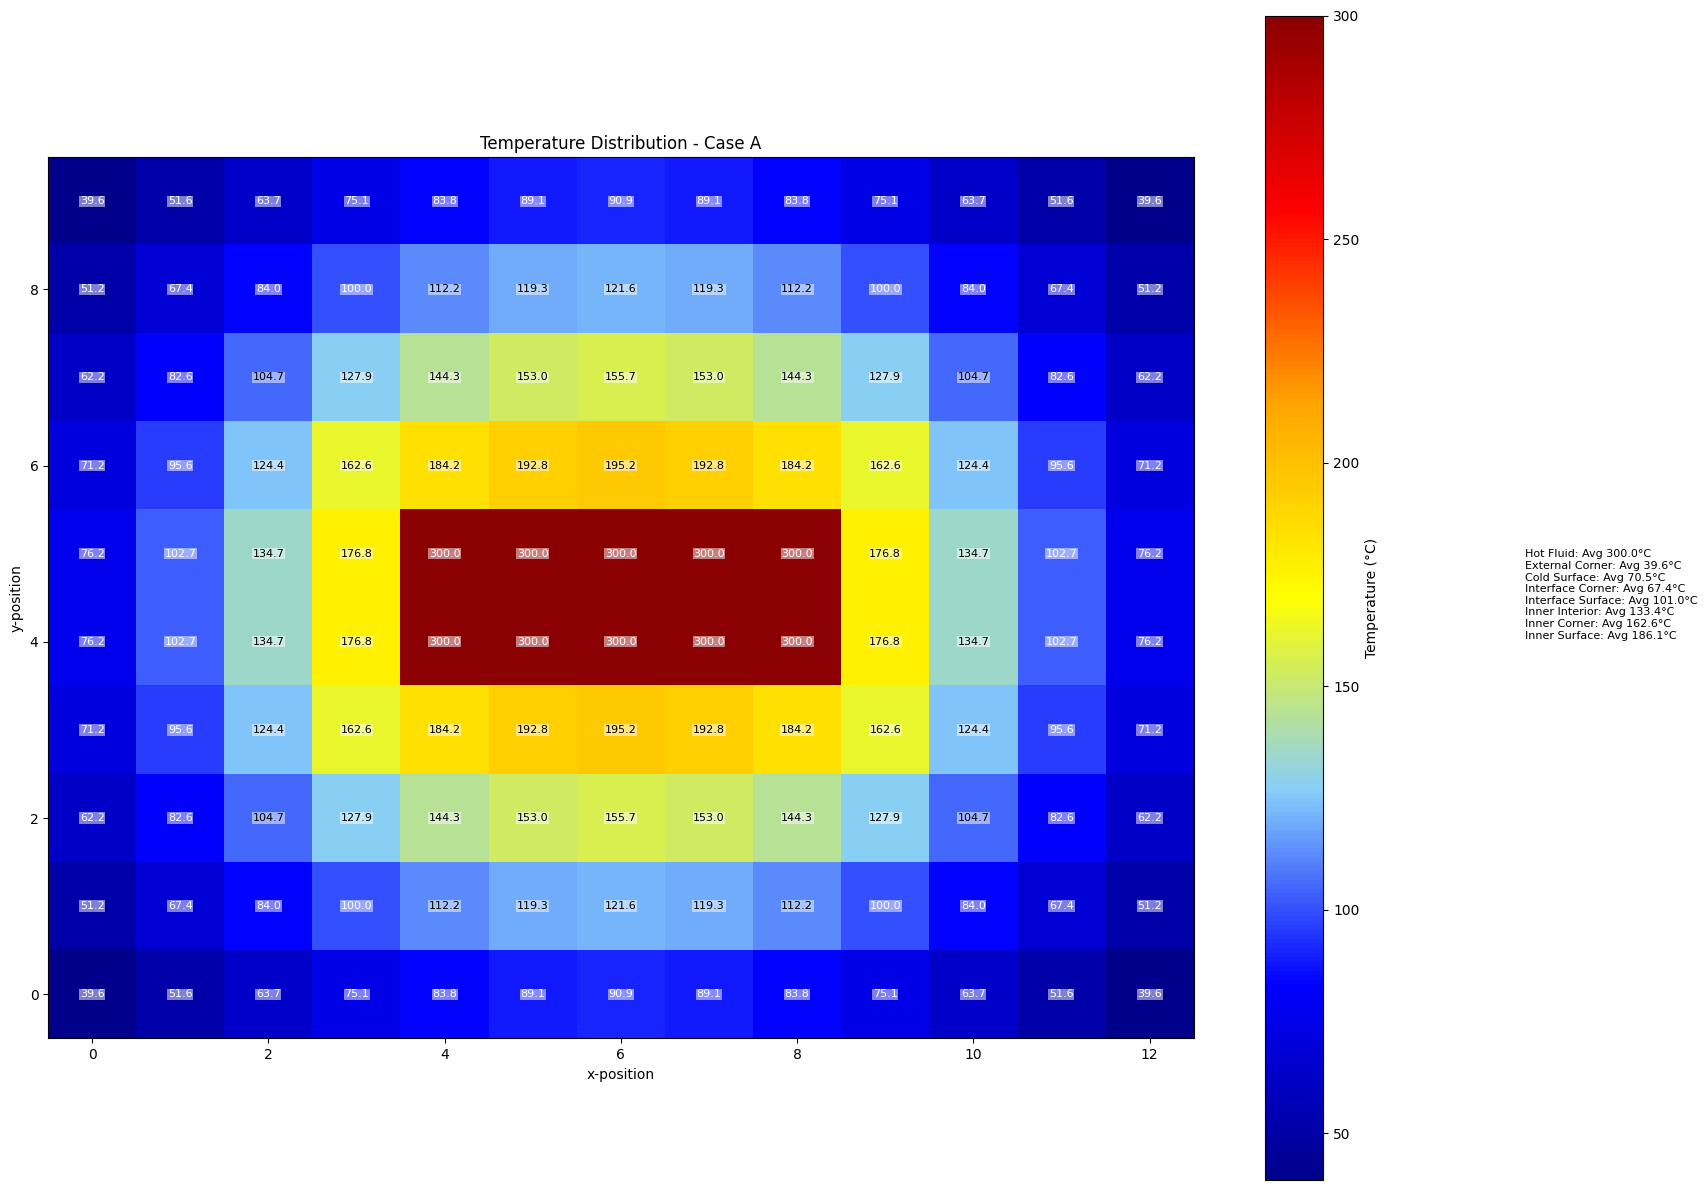

In [12]:
print("\nSolving and printing equations for Case A...")
solver_a = ChimneyAnalysis(case='a')
solver_a.print_equations()
T_a = solver_a.solve()
solver_a.plot_solution(T_a)

In [4]:
def perform_sensitivity_analysis(case='a', compare_points=True):
    """Perform sensitivity analysis with different grid refinements"""
    from scipy.interpolate import interp2d
    import time
    
    # Define refinement factors
    refinement_factors = [1, 2, 4]
    solutions = {}
    solve_times = {}
    
    # Points of interest (in meters)
    points_of_interest = [
        (0.06, 0.08, "Interface Left"),
        (0.10, 0.08, "Center"),
        (0.14, 0.08, "Interface Right"),
        (0.10, 0.12, "Top Center"),
        (0.10, 0.04, "Bottom Center")
    ]
    
    # Solve for each refinement
    for factor in refinement_factors:
        print(f"\nSolving with refinement factor {factor}...")
        solver = ChimneyAnalysis(case=case, refinement_factor=factor)
        
        start_time = time.time()
        T = solver.solve()
        solve_time = time.time() - start_time
        
        solutions[factor] = T
        solve_times[factor] = solve_time
        
        print(f"Grid size: {T.shape}")
        print(f"Solution time: {solve_time:.2f} seconds")
        
        if compare_points:
            print("\nTemperatures at points of interest:")
            dx = 0.20 / (T.shape[1] - 1)
            dy = 0.16 / (T.shape[0] - 1)
            for px, py, name in points_of_interest:
                ix = int(round(px / dx))
                iy = int(round(py / dy))
                temp = T[iy, ix]
                print(f"{name}: {temp:.2f}°C")
        
        solver.plot_solution(T)

    # Compare solutions
    base_T = solutions[1]
    nx_base = base_T.shape[1]
    ny_base = base_T.shape[0]
    x_base = np.linspace(0, 0.20, nx_base)
    y_base = np.linspace(0, 0.16, ny_base)
    
    # Create interpolation function for base solution
    base_interp = interp2d(x_base, y_base, base_T, kind='linear')
    
    for factor in refinement_factors[1:]:
        refined_T = solutions[factor]
        nx_ref = refined_T.shape[1]
        ny_ref = refined_T.shape[0]
        
        # Create refined grid points
        x_refined = np.linspace(0, 0.20, nx_ref)
        y_refined = np.linspace(0, 0.16, ny_ref)
        
        # Interpolate base solution to refined grid
        base_on_refined = base_interp(x_refined, y_refined)
        
        # Calculate differences
        abs_diff = np.abs(refined_T - base_on_refined)
        rel_diff = abs_diff / (np.abs(base_on_refined) + 1e-10) * 100
        
        # Print statistics
        print(f"\nRefinement factor {factor}:")
        print(f"Solution time ratio: {solve_times[factor]/solve_times[1]:.2f}x")
        print(f"Maximum absolute difference: {np.max(abs_diff):.2f}°C")
        print(f"Average absolute difference: {np.mean(abs_diff):.2f}°C")
        print(f"Maximum relative difference: {np.max(rel_diff):.2f}%")
        print(f"Average relative difference: {np.mean(rel_diff):.2f}%")
        
        # Plot differences
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Absolute difference plot
        im1 = ax1.imshow(abs_diff, origin='lower', extent=[0, 0.20, 0, 0.16])
        plt.colorbar(im1, ax=ax1, label='Absolute Difference (°C)')
        ax1.set_title(f'Absolute Difference (Factor {factor})')
        ax1.set_xlabel('x (m)')
        ax1.set_ylabel('y (m)')
        
        # Add points of interest to absolute difference plot
        for px, py, name in points_of_interest:
            ax1.plot(px, py, 'r*', markersize=10)
            ax1.annotate(name, (px, py), xytext=(5, 5), textcoords='offset points')
        
        # Relative difference plot
        im2 = ax2.imshow(rel_diff, origin='lower', extent=[0, 0.20, 0, 0.16])
        plt.colorbar(im2, ax=ax2, label='Relative Difference (%)')
        ax2.set_title(f'Relative Difference (Factor {factor})')
        ax2.set_xlabel('x (m)')
        ax2.set_ylabel('y (m)')
        
        # Add points of interest to relative difference plot
        for px, py, name in points_of_interest:
            ax2.plot(px, py, 'r*', markersize=10)
            ax2.annotate(name, (px, py), xytext=(5, 5), textcoords='offset points')
        
        plt.tight_layout()
        plt.show()

# Add method to ChimneyAnalysis class
ChimneyAnalysis.perform_sensitivity_analysis = staticmethod(perform_sensitivity_analysis)


Solving with refinement factor 1...
Grid size: 13x10
Spacing: 0.2m
Case: a
Processing node at (0,9) - Type: EXTERNAL_CORNER
  Valid neighbors: {'s': (0, 8), 'e': (1, 9)}
Processing node at (1,9) - Type: COLD_SURFACE
  Valid neighbors: {'s': (1, 8), 'e': (2, 9), 'w': (0, 9)}
Processing node at (2,9) - Type: COLD_SURFACE
  Valid neighbors: {'s': (2, 8), 'e': (3, 9), 'w': (1, 9)}
Processing node at (3,9) - Type: COLD_SURFACE
  Valid neighbors: {'s': (3, 8), 'e': (4, 9), 'w': (2, 9)}
Processing node at (4,9) - Type: COLD_SURFACE
  Valid neighbors: {'s': (4, 8), 'e': (5, 9), 'w': (3, 9)}
Processing node at (5,9) - Type: COLD_SURFACE
  Valid neighbors: {'s': (5, 8), 'e': (6, 9), 'w': (4, 9)}
Processing node at (6,9) - Type: COLD_SURFACE
  Valid neighbors: {'s': (6, 8), 'e': (7, 9), 'w': (5, 9)}
Processing node at (7,9) - Type: COLD_SURFACE
  Valid neighbors: {'s': (7, 8), 'e': (8, 9), 'w': (6, 9)}
Processing node at (8,9) - Type: COLD_SURFACE
  Valid neighbors: {'s': (8, 8), 'e': (9, 9), 'w

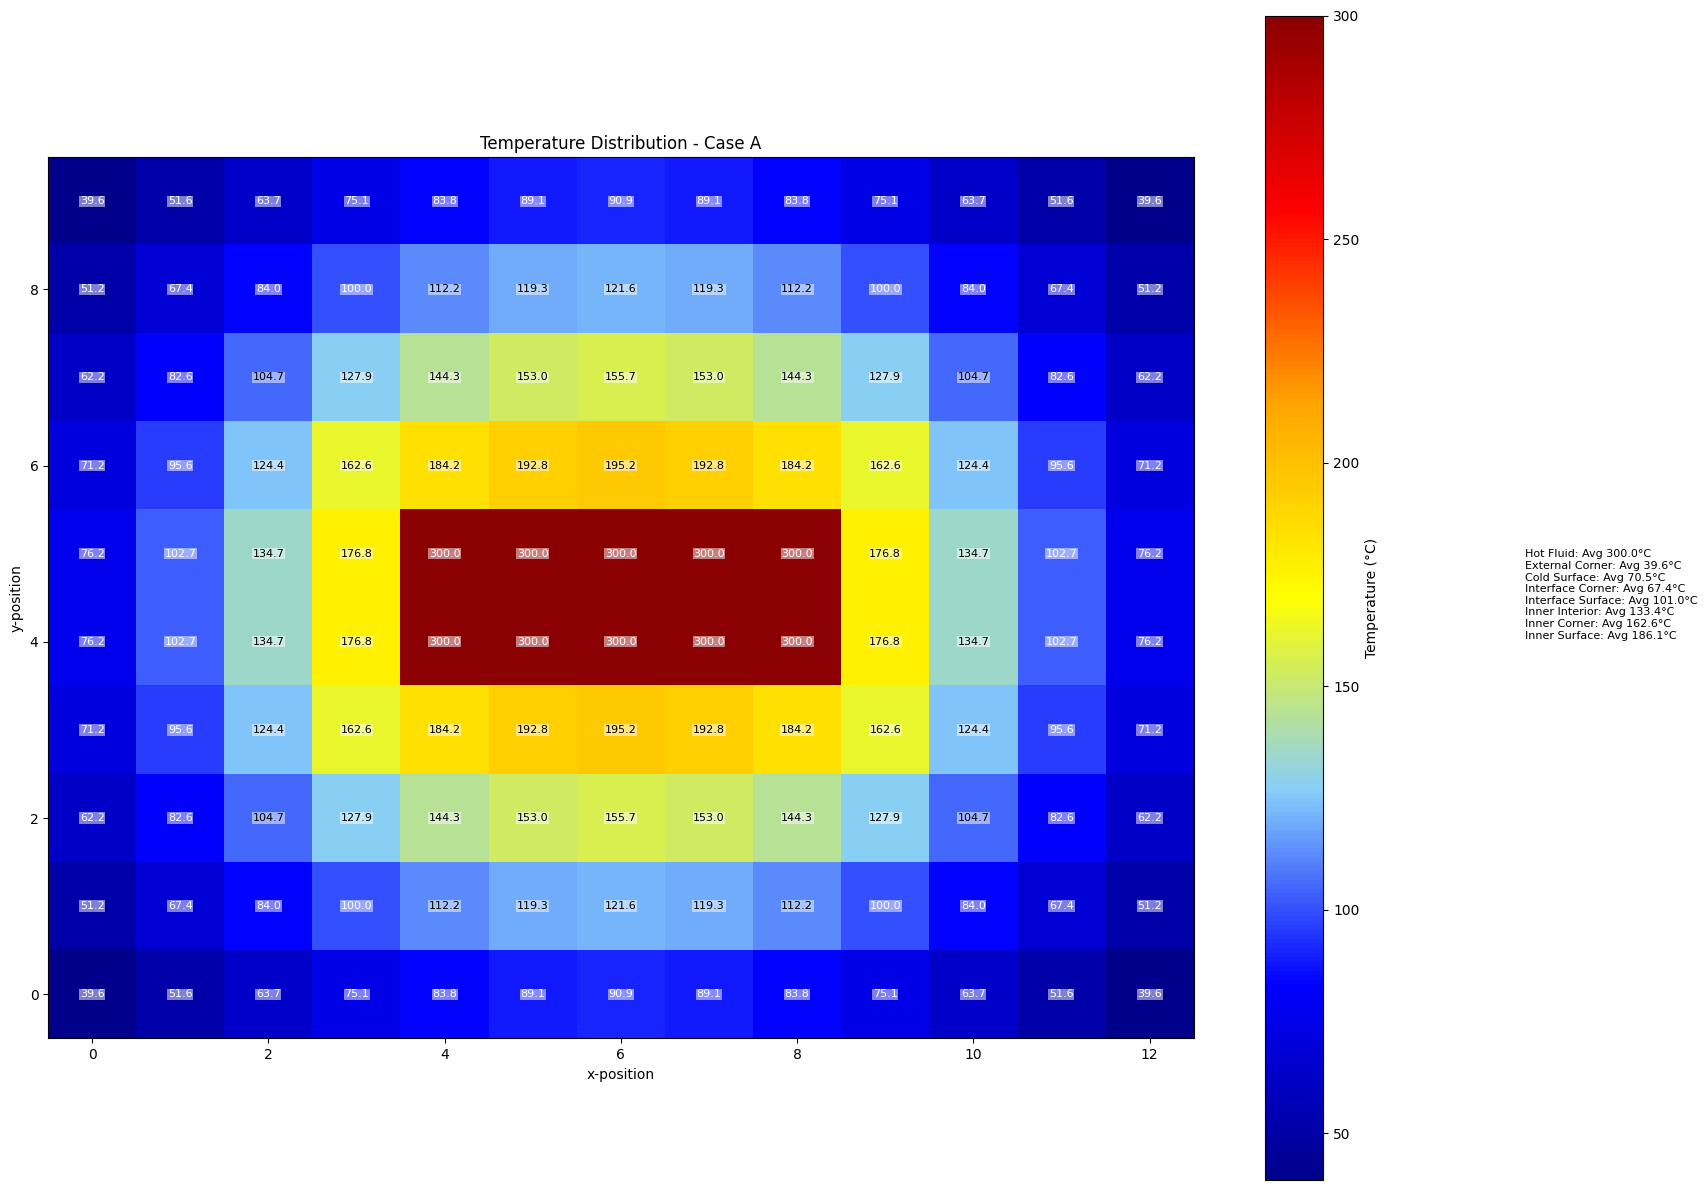


Solving with refinement factor 2...
Grid size: 25x19
Spacing: 0.1m
Case: a
Processing node at (0,18) - Type: EXTERNAL_CORNER
  Valid neighbors: {'s': (0, 17), 'e': (1, 18)}
Processing node at (1,18) - Type: EXTERNAL_CORNER
  Valid neighbors: {'s': (1, 17), 'e': (2, 18), 'w': (0, 18)}


ValueError: Invalid corner position at (1,18)

In [5]:
ChimneyAnalysis.perform_sensitivity_analysis('a')

Performing sensitivity analysis for Case A...

Solving with refinement factor 1...
Grid size: 13x10
Spacing: 0.2m
Case: a
Processing node at (0,9) - Type: EXTERNAL_CORNER
  Valid neighbors: {'s': (0, 8), 'e': (1, 9)}
Processing node at (1,9) - Type: COLD_SURFACE
  Valid neighbors: {'s': (1, 8), 'e': (2, 9), 'w': (0, 9)}
Processing node at (2,9) - Type: COLD_SURFACE
  Valid neighbors: {'s': (2, 8), 'e': (3, 9), 'w': (1, 9)}
Processing node at (3,9) - Type: COLD_SURFACE
  Valid neighbors: {'s': (3, 8), 'e': (4, 9), 'w': (2, 9)}
Processing node at (4,9) - Type: COLD_SURFACE
  Valid neighbors: {'s': (4, 8), 'e': (5, 9), 'w': (3, 9)}
Processing node at (5,9) - Type: COLD_SURFACE
  Valid neighbors: {'s': (5, 8), 'e': (6, 9), 'w': (4, 9)}
Processing node at (6,9) - Type: COLD_SURFACE
  Valid neighbors: {'s': (6, 8), 'e': (7, 9), 'w': (5, 9)}
Processing node at (7,9) - Type: COLD_SURFACE
  Valid neighbors: {'s': (7, 8), 'e': (8, 9), 'w': (6, 9)}
Processing node at (8,9) - Type: COLD_SURFACE
  

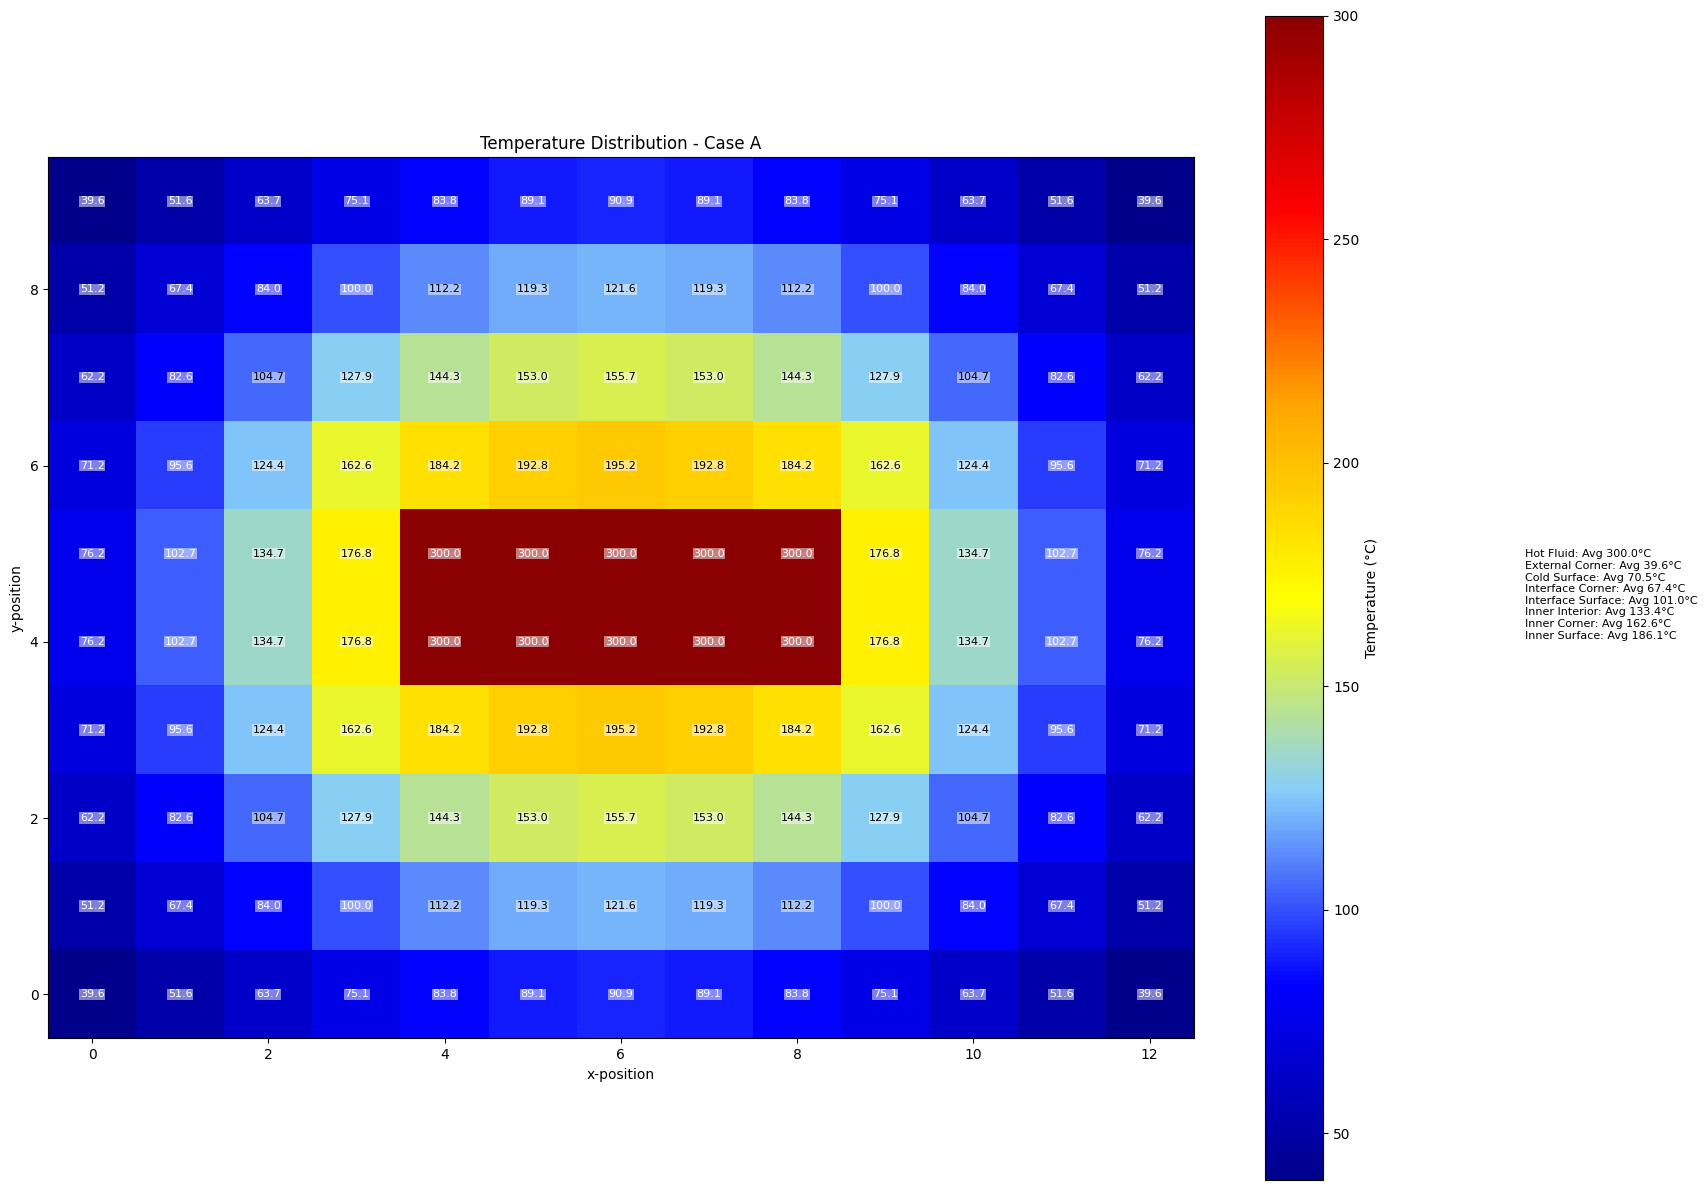


Solving with refinement factor 2...
Grid size: 25x19
Spacing: 0.1m
Case: a
Processing node at (0,18) - Type: EXTERNAL_CORNER
  Valid neighbors: {'s': (0, 17), 'e': (1, 18)}
Processing node at (1,18) - Type: EXTERNAL_CORNER
  Valid neighbors: {'s': (1, 17), 'e': (2, 18), 'w': (0, 18)}


ValueError: Invalid corner position at (1,18)

In [14]:

def perform_sensitivity_analysis(case='a'):
    """Perform sensitivity analysis with different grid refinements"""
    from scipy.interpolate import RegularGridInterpolator
    refinement_factors = [1, 2, 4]
    solutions = {}
    
    for factor in refinement_factors:
        print(f"\nSolving with refinement factor {factor}...")
        solver = ChimneyAnalysis(case=case, refinement_factor=factor)
        T = solver.solve()
        solutions[factor] = T
        solver.plot_solution(T)
        
    # Compare solutions
    print("\nComparing solutions:")
    base_solution = solutions[1]
    
    # Create base grid points
    x_base = np.linspace(0, 1, base_solution.shape[1])
    y_base = np.linspace(0, 1, base_solution.shape[0])
    
    # Create interpolator for base solution
    interpolator = RegularGridInterpolator((y_base, x_base), base_solution, 
                                         method='linear', bounds_error=False)
    
    for factor in refinement_factors[1:]:
        refined_solution = solutions[factor]
        
        # Create refined grid points
        x_refined = np.linspace(0, 1, refined_solution.shape[1])
        y_refined = np.linspace(0, 1, refined_solution.shape[0])
        
        # Create mesh grid for interpolation points
        Y_refined, X_refined = np.meshgrid(y_refined, x_refined, indexing='ij')
        points = np.column_stack((Y_refined.ravel(), X_refined.ravel()))
        
        # Interpolate base solution to refined grid
        base_interpolated = interpolator(points).reshape(refined_solution.shape)
        
        # Calculate differences
        abs_diff = np.abs(refined_solution - base_interpolated)
        rel_diff = abs_diff / (base_interpolated + 1e-10) * 100  # percentage, avoid division by zero
        
        print(f"\nRefinement factor {factor} vs base grid:")
        print(f"Maximum absolute difference: {np.max(abs_diff):.2f}°C")
        print(f"Average absolute difference: {np.mean(abs_diff):.2f}°C")
        print(f"Maximum relative difference: {np.max(rel_diff):.2f}%")
        print(f"Average relative difference: {np.mean(rel_diff):.2f}%")
        
        # Plot difference
        plt.figure(figsize=(10, 8))
        im = plt.imshow(abs_diff, cmap='viridis', origin='lower')
        plt.colorbar(im, label='Absolute Temperature Difference (°C)')
        plt.title(f'Temperature Difference (Refinement {factor}x vs Base)')
        plt.xlabel('x-position')
        plt.ylabel('y-position')
        plt.tight_layout()
        plt.show()

# Perform sensitivity analysis for both cases
print("Performing sensitivity analysis for Case A...")
perform_sensitivity_analysis('a')

print("\nPerforming sensitivity analysis for Case B...")
perform_sensitivity_analysis('b')